# Cars 4 You: Expending Car Evaluations with ML

## 1. Import the needed libraries

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import os

## 2. Data importation and integration

In [2]:
train_data = pd.read_csv('project_data/train.csv')
test_data = pd.read_csv('project_data/test.csv')

In [3]:
data= train_data.copy()

## 3. Data exploration and understanding

### Metadata
- *carID*: An attribute that contains an identifier for each car.
- *Brand*: The car’s main brand (e.g. Ford, Toyota).
- *model*: The car model.
- *year*: The year of Registration of the Car.
- *mileage*: The total reported distance travelled by the car (in
 miles).
- *tax*: The amount of road tax (in £) that, in 2020, was
 applicable to the car in question.
- *fuelType*: Type of Fuel used by the car (Diesel, Petrol, Hybrid,
 Electric).
- *mpg*: Average Miles per Gallon.
- *engineSize*: Size of Engine in liters (Cubic Decimeters).
- *paintQuality%*:  The mechanic’s assessment of the cars’ overall paint
 quality and hull integrity (filled by the mechanic
 during evaluation). 
- *previousOwners*: Number of previous registered owners of the vehicle.
- *hasDamage*:  Boolean marker filled by the seller at the time of
 registration stating whether the car is damaged or
 not.
- *price*: The car’s price when purchased by Cars 4 You (in £).

### 3.1. Data Overview

In [ ]:
#overview the dataset
data.info()

In [ ]:
#first 20 rows
data.head(20)

In [ ]:
#last 20 rows
data.tail(20)

In [ ]:
#Descriptive statistics for numerical data
data.describe().T

In [ ]:
#Descriptive statistics for categorical data
data.describe(include = ['O'])

In [4]:
#separate numerical and categorical features 

metric_features = ['year', 'mileage', 'tax', 'mpg',
                    'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']

non_metric_features= ['Brand','model','transmission','fuelType']

identifier = 'carID'

target = 'price'

In [ ]:
#checking what are the unique values of categorical variables
for col in non_metric_features:
    print(f"\nColumn: {col}")
    print(data[col].unique())

### 3.2. Checking Duplicates

In [ ]:
#Number of duplicates
data.duplicated().sum()

### 3.3. Checking Missing Values

In [ ]:
#Number of missing values
data.isna().sum()

In [ ]:
#Number of missing values in each column as a percentage
data.isna().sum()/len(data) * 100

### 3.4. Checking Outliers

In [5]:
# Checking outliers of numerical variables through the visualization of boxplots

def plot_multiple_boxplots(data, feats, title="Numeric Variables' Box Plots"):

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(4, ceil(len(feats) / 4), figsize=(40, 30))

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), feats):
        sns.boxplot(x=data[feat], ax=ax, color="#5dade2")
        ax.set_title(feat)

    # Layout
    plt.suptitle(title)
    plt.show()

    return

In [ ]:
plot_multiple_boxplots(data, metric_features)

### 3.5. Checking Distributions

In [ ]:
df= pd.DataFrame(data[metric_features])

In [ ]:
# Creating histograms to see the distribrution of numerical variables

num_cols = df.select_dtypes(include=['number']).columns
n = len(num_cols)

# Adjust layout
fig, axes = plt.subplots(nrows=(n // 3) + 1, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='#5dade2', edgecolor='black')  
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('frequency')

# Remove empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Checking Categorical Variables

In [ ]:
# Creating barplots to understand the categorical data

sns.set_style('white')  
sns.set_palette(['#5dade2'])  

# Create 4 subplots stacked vertically
fig, ax = plt.subplots(nrows=4, ncols=1, dpi=300, figsize=(20, 40))
fig.patch.set_facecolor('white') 

# Plot each variable in its own row
sns.countplot(data=test_data, x='Brand', ax=ax[0])
sns.countplot(data=test_data, x='model', ax=ax[1])
sns.countplot(data=test_data, x='transmission', ax=ax[2])
sns.countplot(data=test_data, x='fuelType', ax=ax[3])

# Improve spacing between plots
plt.tight_layout()
plt.show()

### 3.6. Checking Correlation between Variables

In [ ]:
# Check correlation between variables 
# We are going to use spearman correlation since our variables do not follow a normal distribution
cor_spearman = data[metric_features].corr(method ='spearman')
cor_spearman

In [ ]:
# Create correlation matrix to facilitate interpretation

def cor_heatmap(cor):
    plt.figure(figsize=(12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(cor, dtype=bool))

    # Plot heatmap 
    sns.heatmap(
        data=cor,
        mask=mask,
        annot=True,
        cmap='YlGnBu',   
        fmt='.2f',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title("Spearman Correlation Matrix", fontsize=14)
    plt.show()

In [ ]:
cor_heatmap(cor_spearman)

In [ ]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot and use historgrams in the diagonal
sns.pairplot(df[metric_features], diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

# Create eda directory 
if not os.path.exists(os.path.join('..', 'figures', 'eda')):
    os.makedirs(os.path.join('..', 'figures', 'eda'))
    
plt.savefig(os.path.join('..', 'figures', 'eda', 'pairwise_numeric_scatterplots.png'), dpi=200)
plt.show()

## 4. Data preparation

### 4.1. Set index

In [6]:
# Set index to CarID as each car has its own unique identifier
data.set_index('carID', inplace = True)

### 4.2. Slipt the data into train and validation dataset

#### The Hold Out Method

In [7]:
X = data.drop('price', axis = 1) # In X, the target variable will be removed and the dataset will be used as the training set
y = data['price']  # y corresponds to the target variable

In [8]:
# Splits the dataset

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,  # 30% will be used for validation 
                                                  random_state = 0,      # Ensures the split is always the same every time the code runs
                                                  shuffle = True)        # Shuffles the data before spliting to avoid bias

### 4.3. Changing datatypes

In [9]:
# Rounds the floats and changes them to integers

#year to integer
X_train['year'] = X_train['year'].round().astype('Int32')
X_val['year'] = X_val['year'].round().astype('Int32')

#previousOwners to integer
X_train['previousOwners'] = X_train['previousOwners'].round().astype('Int32')
X_val['previousOwners'] = X_val['previousOwners'].round().astype('Int32')

#hasDamaged to boolean
X_train['hasDamage'] = X_train['hasDamage'].astype('Int8')
X_val['hasDamage'] = X_val['hasDamage'].astype('Int8')

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 42520 to 15659
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           52128 non-null  object 
 1   model           52136 non-null  object 
 2   year            52130 non-null  Int32  
 3   transmission    52086 non-null  object 
 4   mileage         52157 non-null  float64
 5   fuelType        52160 non-null  object 
 6   tax             47671 non-null  float64
 7   mpg             47683 non-null  float64
 8   engineSize      52118 non-null  float64
 9   paintQuality%   52091 non-null  float64
 10  previousOwners  52090 non-null  Int32  
 11  hasDamage       52087 non-null  Int8   
dtypes: Int32(2), Int8(1), float64(5), object(4)
memory usage: 4.7+ MB


### 4.4. Handling Incoherencies

#### 4.4.1. Categorical Variables 

##### 4.4.1.1. Correcting Spelling Mistakes

In [11]:
#correcting spelling mistakes of 'brand' for X_train and X_val

correct_brand = {
    'VW': ['V', 'vw', 'v', 'W', 'w'],
    'Toyota': ['Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot'],
    'Audi': ['udi', 'AUDI', 'audi', 'Aud', 'aud', 'UDI', 'AUD'],
    'Ford': ['FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    'BMW': ['MW', 'bmw', 'BM', 'mw'],
    'Skoda': ['koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    'Opel': ['Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    'Mercedes': ['mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE'],
    'Hyundai': ['yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'ud', 'hyunda']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_brand.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["Brand"] = X_train["Brand"].replace(replacement_dict)
X_val["Brand"] = X_val["Brand"].replace(replacement_dict)

# Verify the cleaning
print(X_train["Brand"].unique())
print(X_val["Brand"].unique())

['Mercedes' 'Ford' 'Hyundai' 'VW' 'Opel' 'Audi' 'Toyota' 'BMW' nan 'Skoda']
['Mercedes' 'Opel' 'Ford' 'VW' 'Toyota' nan 'BMW' 'Skoda' 'Audi' 'Hyundai']


In [12]:
##correcting spelling mistakes of 'model' for X_train and X_val

correct_model = {
    'Golf': [' GOLF', ' Gol', ' golf', 'golf', ' Golf', ' gol', ' GOL', 'Gol', 'GOLF'],
    'Yaris': [' Yaris', ' YARIS', ' Yari', ' yaris', ' yari', 'Yari', ' YARI', 'yaris', 'YARIS'],
    'Q2': [' q2', ' Q2'],
    '2 Series': [' 2 series', ' 2 serie', '2 Series', ' 2 SERIES', ' 2 Serie', '2 Serie', ' 2 Series'],
    '3 Series': [' 3 Series', ' 3 Serie', ' 3 series', ' 3 SERIES', ' 3 serie', '3 Serie'],
    'A3': [' A3', ' a3'],
    'Octavia': [' Octavi', ' OCTAVIA', ' Octavia', ' octavia', 'Octavi', 'octavia', ' octavi', ' OCTAVI'],
    'Passat': [' PASSAT', ' passat', ' Passa', 'Passat', ' Passat', 'PASSAT', ' PASSA'],
    'Insignia': [' Insigni', ' INSIGNIA', ' insignia', ' Insignia', ' INSIGNI', 'Insigni'],
    'Fabia': [' Fabia', ' fabia', ' FABIA', ' Fabi', 'FABIA'],
    'A Class': [' A Clas', ' A Class', ' a class', ' A CLASS', 'a class', 'A CLASS', ' a clas'],
    'Ka+': [' Ka+', ' KA+', ' ka+', 'ka+'],
    'GLC Class': [' GLC Class', ' GLC CLASS', ' GLC Clas', ' glc class', ' glc clas'], 
    'I30': [' i30', ' I30'],
    'C Class': [' C Clas', ' C CLASS', ' c class', 'C Clas', ' C CLAS', 'c class', ' c clas', ' C Class', 'C CLASS'],
    'Polo': [' POLO', ' Polo', ' polo', ' Pol', ' POL', 'Pol', 'POLO'],
    'E Class': [' E Class', ' E Clas', ' E CLASS', ' e class', 'E CLASS', 'e class'],
    'Q5': [' Q5', ' q5', 'q5'],
    'Up': ['U', ' up', ' UP', ' Up', ' U', 'UP'],
    'Fiesta': [' FIESTA', ' fiesta', ' Fiest', ' Fiesta', 'fiesta', 'Fiest', ' FIESTA', 'FIESTA', ' fiest'],
    'C-HR': [' C-H', ' c-hr', ' C-HR', ' c-h'],
    'Mokka X': [' mokka x', ' MOKKA X', ' Mokka X'],
    'Corsa': [' Corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', 'corsa'],
    'Astra': [' ASTRA', ' Astr', ' Astra', ' astra', 'ASTRA', 'astra'],
    'TT': [' tt', ' TT', ' T'],
    '5 Series': [' 5 Series', ' 5 Serie', ' 5 SERIES', ' 5 series', '5 SERIES', ' 5 SERIE'],
    'Aygo': [' aygo', ' ayg', ' AYGO', ' Ayg', ' Aygo', 'aygo', ' AYG'],
    '4 Series': [' 4 SERIES', ' 4 Serie', ' 4 serie', '4 series', '4 Series', ' 4 Series', ' 4 series'],
    'SLK': [' slk', ' SLK'],
    'Viva': [' viva', ' Viva', ' VIVA', ' Viv', 'viva'],
    'Focus': [' Focus', ' Focu', ' FOCUS', ' focus', ' FOCU', 'focus', 'Focu', ' focu', 'FOCUS'],
    'EcoSport': [' EcoSpor', ' ECOSPORT', ' ecosport', ' EcoSport'],
    'X-CLASS': [' x-clas', ' X-CLAS', ' x-class', ' X-CLASS'],
    'CL Class': [' cl class', ' CL Clas', ' CL CLASS', ' CL Class'],
    'IX20': [' ix20', ' IX20'],
    'Rapid': [' Rapi', ' rapid', ' Rapid'],
    'Auris': [' Auris', ' AURIS', ' auris', ' Auri'],
    'I20': [' i20', ' I20'],
    'X3': [' x3', ' X3'],
    'A8': [' A8', 'a8'],
    'GLS Class': [' GLS Clas', ' GLS CLASS', ' gls class', ' GLS Class'],
    'B-MAX': [' B-MA', ' B-MAX', 'B-MA', ' b-max'],
    'A4': [' A4', ' a4'],
    'Kona': [' KONA', ' Kon', ' Kona', ' KON', ' kona'],
    'I10': [' i10', ' I10'],
    'A1': [' A1', ' a1'],
    'Mokka': [' Mokka ', ' Mokk', ' Mokka', ' mokka ', ' mokka', ' MOKKA', 'Mokka ', 'Mokk'],
    'S-MAX': [' S-MA', ' s-max', ' S-MAX', ' s-ma'],
    'X2': [' x2', ' X2'],
    'Crossland X': [' crossland x', ' CROSSLAND X', ' Crossland X'],
    'Tiguan': [' Tiguan', ' tiguan', ' Tigua', ' TIGUAN', ' TIGUA', 'Tigua', 'TIGUAN', 'tiguan', ' tigua'],
    'A5': [' A5', ' a5', 'a5'],
    'GLE Class': [' GLE Clas', ' GLE Class', ' gle class', ' GLE CLASS'],
    'Zafira': [' Zafira', ' Zafir', ' ZAFIRA', ' zafira', 'Zafir', ' ZAFIR'],
    'Ioniq': [' Ioni', ' Ioniq', ' IONIQ', 'IONIQ', ' ioniq'],
    'A6': [' A6', ' a6'],
    'Yeti Outdoor': [' yeti outdoor', ' Yeti Outdoor', ' YETI OUTDOOR', ' Yeti Outdoo', ' yeti outdoor', 'yeti outdoor', ' yeti outdoo'],
    'X1': [' x1', 'x1', ' X1'],
    'Scala': [' SCALA', ' Scala', ' scala', ' Scal', ' scal'],
    'S Class': [' S Class', ' S Clas', ' s class', ' S CLASS'],
    '1 Series': [' 1 Series', ' 1 SERIES', ' 1 Serie', ' 1 series', '1 SERIES', ' 1 SERIE', '1 series', ' 1 serie'],
    'Kamiq': [' KAMIQ', ' KAMI', ' kamiq', ' Kamiq'],
    'Kuga': [' Kug', ' KUGA', ' kuga', 'Kuga', ' Kuga', 'kuga'],
    'Tourneo Connect': [' tourneo connect', ' Tourneo Connect'],
    'Q7': [' q7', ' Q7'],
    'GLA Class': [' GLA Class', ' GLA CLASS', ' GLA Clas', ' gla class'],
    'Arteon': [' arteon', ' Arteon', ' Arteon'],
    'SL CLASS': [' SL CLAS', ' SL CLASS', ' sl class', ' SL'],
    'Tucson': [' Tucson', ' TUCSON', ' Tucso', ' tucson', ' TUCSO', 'Tucso'],
    'Santa Fe': [' Santa F', ' santa fe', ' SANTA FE', ' Santa Fe'],
    'Grandland X': [' Grandland X', ' grandland x', ' GRANDLAND X'],
    'RAV4': [' rav4', 'RAV4', 'RAV', ' RAV', 'rav4', ' rav', ' RAV4'],
    'Touran': [' Touran', 'Toura', ' TOURAN', ' touran', ' Toura', ' TOURA'],
    'Citigo': [' Citig', ' citigo', ' Citigo', ' CITIGO', 'CITIGO'],
    'Roomster': [' Roomste', ' Roomster'],
    'Prius': [' PRIUS', ' Prius', 'Prius', ' prius'],
    'Corolla': [' corolla', ' COROLLA', ' Coroll', ' Corolla', 'corolla'],
    'B Class': [' b class', ' B Clas', ' B Class', ' B CLASS', 'b class'],
    'Sharan': [' sharan', ' Shara', ' Sharan', ' SHARAN'],
    'Kodiaq': [' Kodia', ' kodiaq', 'kodiaq', ' KODIAQ', ' Kodiaq'],
    'V Class': [' V Clas', ' V CLASS', ' V Class', ' v class'],
    'Caddy Maxi Life': [' Caddy Maxi Lif', ' Caddy Maxi Life'],
    'Superb': [' Superb', ' Super', ' SUPERB', ' superb', ' super'],
    'T-Roc': [' T-Roc', ' T-RO', ' t-roc', ' T-Ro', ' T-ROC'],
    'Combo Life': [' COMBO LIFE', ' combo life', ' Combo Lif', 'COMBO LIFE', ' Combo Life'],
    'Beetle': [' Beetl', ' Beetle', ' beetle'],
    'Galaxy': [' GALAXY', ' Galax', ' galaxy', ' Galaxy'],
    'M3': [' M3', ' m3'],
    'Gtc': [' gtc', ' GTC', ' gtc', 'gtc', 'GTC'],
    'X4': [' X4', ' x4'],
    'KA': [' Ka', ' ka', ' K', ' KA'],
    'IX35': [' ix35', ' IX35'],
    'Grand Tourneo Connect': [' Grand Tourneo Connec', ' Grand Tourneo Connect'],
    'M4': [' m4', ' M4'],
    'Tourneo Custom': [' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    'Z4': [' Z4', ' z4'],
    'X5': [' X5', ' x5'],
    'Meriva': [' Meriva', ' MERIVA', ' Meriv', ' meriva'],
    'RS6': [' RS6'],
    'Verso': [' VERSO', ' verso', ' Verso', ' Vers'],
    'Touareg': [' Touareg', ' TOUAREG', ' touareg', ' Touare'],
    'Mondeo': [' MONDEO', ' Mondeo', ' mondeo', ' MONDE', ' Monde'],
    'Shuttle': [' shuttle', ' Shuttle', ' SHUTTLE'],
    'CLS Class': [' CLS Class', ' cls class', ' CLS Clas', ' CLS CLASS'], 
    'C-MAX': [' C-MAX', ' c-max', ' C-MA'],
    'Puma': [' puma', ' PUMA', ' Puma', 'Pum', ' Pum'],
    'CLA Class': [' CLA Class', ' CLA CLASS', ' cla class', ' CLA Clas'],
    'I40': [' I40', ' i40'],
    'Q3': [' q3', ' Q3'],
    'Tiguan Allspace': [' TIGUAN ALLSPACE', ' tiguan allspace', ' Tiguan Allspac', ' Tiguan Allspace'],
    '6 Series': [' 6 SERIES', ' 6 series', ' 6 Series', ' 6 Serie'],
    'Caravelle': [' caravelle', ' Caravell', ' Caravelle'],
    'Karoq': [' Karoq', ' karoq', ' KAROQ', ' Karo'],
    'I3': [' i3', 'i3', ' I3'],
    'Grand C-MAX': [' GRAND C-MAX', ' grand c-max', ' Grand C-MA', ' Grand C-MAX'],
    'T-Cross': [' T-Cros', ' T-CROSS', ' T-Cross', ' t-cros', ' t-cross'],
    'A7': [' a7', ' A7'],
    'Golf SV': [' Golf SV', ' golf sv', ' GOLF SV'],
    'A': [' a', ' A'],
    'GT86': [' gt86', ' GT86'],
    'Yeti': [' yeti', ' Yet', ' Yeti', ' YETI'],
    'X': [' x', ' X'],
    'Land Cruiser': [' Land Cruise', ' Land Cruiser', ' land cruiser'],
    'EDGE': [' Edge', ' edge', ' Edg', ' EDGE'],
    'X6': [' X6'],
    'Fusion': [' Fusion', ' fusion'],
    'GL Class': [' GL CLASS', ' gl class', ' GL Class', ' GL Clas'],
    'Scirocco': [' scirocco', ' SCIROCCO', ' Scirocc', ' Scirocco'],
    'Z3': [' Z3'],
    'Hilux': [' hilux', ' Hilux', ' Hilu', ' HILU'],
    'Amarok': [' amarok', ' Amarok', ' Amaro'],
    'CC': [' cc', ' CC'],
    '7 Series': [' 7 Serie', ' 7 SERIES', ' 7 series', ' 7 Series'],
    'Avensis': [' AVENSIS', ' avensis', ' Avensis'],
    'M Class': [' m class', ' M CLASS', ' M Class', ' M Clas', ' M CLAS'],
    'Grandland': [' grandland ', ' Grandland '],
    'Zafira Tourer': [' Zafira Toure', ' ZAFIRA TOURER', ' Zafira Tourer', ' zafira tourer'],
    'R8': [' R8', ' r8'],
    'Mustang': [' mustang', ' Mustang'],
    'Q8': [' Q8'],
    'CLK': [' CLK'],
    'RS3': [' RS3'],
    'Jetta': [' JETTA', ' Jetta', ' jetta', 'Jetta' ],
    'Supra': [' Supra'],
    'X7': [' X7'],
    'SQ7': [' SQ7', ' sq7'],
    'S3': [' s3', ' S3'],
    'Arteon': [' Arteo', 'Arteo', ' ARTEON', ' arteon', ' Arteon'],
    'GLB Class': [' glb class', ' GLB Class'],
    'Adam': [' Ada', ' adam', ' ADAM', ' Adam'],
    'M5': [' M5',' m5'],
    'Golf S': [' golf s', ' Golf S'],
    'Vectra': ['Vectra', ' Vectra', ' VECTRA', 'VECTRA'],
    '8 Series': [' 8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    'Urban Cruiser': [' Urban Cruise', ' Urban Cruiser'],
    'Fox': ['fox', ' fox', ' Fox'], 
    'Q': [' Q'], 
    'M2': [' M2'], 
    'RS4':[' RS4'], 
    'Veloster': [' Veloster', ' Veloste'],  
    'IQ': [' IQ'], 
    'Agila': [' AGILA', ' Agila'], 
    'I2': [' I2'], 
    'Antara': [' Antara'], 
    'G Class': [' G Class'], 
    'Caddy Life': [' Caddy Life', ' Caddy'],
    'R Class': [' R Class'], 
    'I800': [' I800'],
    'Amica': [' Amica'], 
    'Crossland': [' Crossland '],
    'Proace Verso': [' proace verso', ' PROACE VERSO', 'PROACE VERSO'],
    'Camry': [' Camry', 'Camry', ' Camr'], 
    'Tigra': [' Tigra'], 
    'Eos': [' Eos'], 
    'M': [' M'],
    'California': [' Californi', ' California'], 
    'Ampera': [' Ampera'], 
    'I1': [' I1'], 
    'S5': [' S5'], 
    'CLC Class': [' CLC Class'], 
    'Shara': [' SHARA'], 
    'I8': [' i8', 'i8'], 
    'RS7': [' RS7'], 
    'Transit Tourneo': [' Transit Tourneo'], 
    'I4': [' I4'], 
    'S4':[' S4'], 
    'Terracan': [' Terracan'], 
    'Cascada': [' Cascada'], 
    'S8': [' S8'], 
    'A2':[' A2'], 
    'Vivaro':[' Vivaro'],
    'RS5':[' RS5'],
    'SQ5':[' SQ5'], 
    'Getz':[' Getz'], 
    'M6':[' M6'], 
    'Caddy Maxi': [' Caddy Maxi'], 
    'Z':[' Z'], 
    'Verso-S': [' Verso-S'], 
    'Kadjar': [' Kadjar'], 
    'I80': [' I80'], 
    'Streetka': [' Streetka'],
    'RS': [' RS'], 
    'I': [' i'], 
    'Ranger': [' Ranger'], 
    'IX2': [' IX2'], 
    'Escort': [' Escort'],
    'Accent': [' Accent']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_model.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["model"] = X_train["model"].replace(replacement_dict)
X_val["model"] = X_val["model"].replace(replacement_dict)

# Verify the cleaning
print(X_train["model"].unique())
print(X_val["model"].unique())

['E Class' 'Focus' 'C Class' 'IX20' 'Golf' 'I10' 'T-Cross' 'Corsa' 'A4'
 'Polo' 'Tucson' 'Kuga' 'Corolla' 'Yaris' 'Q3' 'A Class' 'A1' 'A5' 'Q5'
 'GLE Class' '3 Series' 'Fiesta' 'T-Roc' 'Insignia' 'GLC Class' 'X1'
 'Astra' 'Q2' 'Aygo' 'C-MAX' 'Q' '2 Series' 'A3' 'Touran' 'TT' 'Santa Fe'
 'C-HR' 'Superb' 'EDGE' 'S Class' 'CL Class' 'Ka+' 'Octavia' 'Arteon' 'X4'
 'Z4' nan 'EcoSport' 'Yeti Outdoor' 'Meriva' 'I20' 'Hilux' 'X5' 'M4'
 'CLA Class' '1 Series' 'Mokka X' 'Prius' 'X2' '4 Series' 'S4' 'Fabia'
 'Auris' 'Galaxy' 'Citigo' 'A6' 'RAV4' 'Passat' 'Grand C-MAX' 'Adam'
 'GLA Class' 'G Class' 'Zafira' 'Touareg' 'Sharan' 'Mokka' 'Tiguan'
 'Ioniq' 'Q7' 'Viva' 'X3' 'Tiguan Allspace' 'B Class' 'Up' 'Crossland X'
 'CLS Class' 'SLK' 'Kodiaq' 'Mondeo' 'B-MAX' 'Caddy Life' 'SL CLASS' 'A7'
 'A' 'I30' 'Yeti' 'Grandland X' 'Tourneo Custom' 'Antara' 'Avensis' 'X6'
 '5 Series' 'GL Class' 'IX35' 'Kamiq' 'KA' 'Caravelle' 'Karoq' 'Scala'
 'V Class' 'Golf SV' 'Verso' 'Kona' '7 Series' '6 Series' 'SQ7' 'Golf 

In [13]:
##correcting spelling mistakes of 'transmission' for X_train and X_val

correct_transmission = {
    'Semi-Auto': ['Semi-Aut', 'semi-auto', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT', 'EMI-AUTO', 'emi-Aut', 'emi-auto', 'semi-aut'],
    'Manual': ['anual', 'manual', 'Manua', 'MANUAL', ' Manual ', 'ANUAL', 'manua', 'anua', 'MANUA', ' manual ', ' MANUAL ', ' Manual', 'Manual ', 'manual '],
    'Automatic': ['AUTOMATIC', 'automatic', 'Automati', 'utomatic', 'UTOMATIC', 'automati', 'AUTOMATI', 'utomati'],
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_transmission.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["transmission"] = X_train["transmission"].replace(replacement_dict)
X_val["transmission"] = X_val["transmission"].replace(replacement_dict)

#replacing the 'unknown' and 'other' variable with a missing value
X_train["transmission"] = X_train["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)
X_val["transmission"] = X_val["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)

# Verify the cleaning
print(X_train["transmission"].unique())
print(X_val["transmission"].unique())

['Semi-Auto' 'Automatic' 'Manual' nan]
['Semi-Auto' 'Manual' nan 'Automatic']


In [14]:
##correcting spelling mistakes of 'fuelType' for X_train and X_val

correct_fuelType = {
    'Petrol': ['etrol', 'petrol', 'PETROL', 'Petro', 'petro', 'ETROL', 'PETRO', 'etro', 'ETRO'],
    'Diesel': ['diesel','iesel','Diese','DIESEL','DIESE','IESEL','iese','diese','IESE'],
    'Hybrid': ['HYBRID','ybri','Hybri','ybrid','hybrid','YBRID','HYBRI'],
    'Other': ['ther','Othe','OTHER','other']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_fuelType.items() for variant in variants}

# Replace incorrect brand names with the correct ones
X_train["fuelType"] = X_train["fuelType"].replace(replacement_dict)
X_val["fuelType"] = X_val["fuelType"].replace(replacement_dict)

#replacing the 'other' variable with a missing value 
X_train["fuelType"] = X_train["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)
X_val["fuelType"] = X_val["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)

# Verify the cleaning
print(X_train["fuelType"].unique())
print(X_val["fuelType"].unique())

['Diesel' 'Petrol' 'Hybrid' nan 'Electric']
['Diesel' 'Petrol' nan 'Hybrid']


##### 4.4.1.2. Check if the Models correspond to the Brand

**Audi**

In [15]:
#Check the models of Audi
audi = X_train[X_train['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

['A',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

In [16]:
#Check the models of Audi
audi = X_val[X_val['Brand'].str.lower() == 'audi']
unique_audi_models_v = sorted(audi['model'].dropna().unique())
unique_audi_models_v

['A',
 'A1',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'Q',
 'Q2',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'S3',
 'S4',
 'S5',
 'S8',
 'SQ5',
 'SQ7',
 'TT']

- All models seem to correspond to Audi cars, except for models 'A' and 'Q'. There are no models in Audi that are named 'A' and 'Q' solely, normally there are followed by a number, for example, 'A1' or 'Q3' as seen in the dataset. 
- Since it might be a problem of data collection, in a way that is missing a number after the letter, we have decided to replace these values by missing values. 

In [17]:
#replacing model 'A' by missing values
X_train.loc[X_train["model"] == 'A', "model"] = np.nan
X_val.loc[X_val["model"] == 'A', "model"] = np.nan

In [18]:
#replacing model 'Q' by missing values
X_train.loc[X_train["model"] == 'Q', "model"] = np.nan
X_val.loc[X_val["model"] == 'Q', "model"] = np.nan

**BMW**

In [19]:
#Check the models of 'BMW'
BMW = X_train[X_train['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z',
 'Z3',
 'Z4']

In [20]:
#Check the models of 'BMW'
BMW = X_val[X_val['Brand'].str.lower() == 'bmw']
unique_bmw_models_v = sorted(BMW['model'].dropna().unique())
unique_bmw_models_v

['1 Series',
 '2 Series',
 '3 Series',
 '4 Series',
 '5 Series',
 '6 Series',
 '7 Series',
 '8 Series',
 'I3',
 'I8',
 'M',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'X',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'Z3',
 'Z4']

- Similarly to 'Audi', in 'BMW' there are also models that should be followed by a number, which are 'X', 'Z', 'I' and 'M'.
- Therefore, we are going to replace it by missing values, for the same reason. 

In [21]:
#replacing model 'X' by missing values
X_train.loc[X_train["model"] == 'X', "model"] = np.nan
X_val.loc[X_val["model"] == 'X', "model"] = np.nan

In [22]:
#replacing model 'Z' by missing values
X_train.loc[X_train["model"] == 'Z', "model"] = np.nan

In [23]:
#replacing model 'I' by missing values
X_train.loc[X_train["model"] == 'I', "model"] = np.nan

In [24]:
#replacing model 'M' by missing values
X_train.loc[X_train["model"] == 'M', "model"] = np.nan
X_val.loc[X_val["model"] == 'M', "model"] = np.nan

**Ford**

In [25]:
#Check the models of 'Ford'
Ford = X_train[X_train['Brand'].str.lower() == 'ford']
unique_ford_models = sorted(Ford['model'].dropna().unique())
unique_ford_models

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Escort',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'Ranger',
 'S-MAX',
 'Streetka',
 'Tourneo Connect',
 'Tourneo Custom']

In [26]:
#Check the models of 'Ford'
Ford = X_val[X_val['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

['B-MAX',
 'C-MAX',
 'EDGE',
 'EcoSport',
 'Fiesta',
 'Focus',
 'Fusion',
 'Galaxy',
 'Grand C-MAX',
 'Grand Tourneo Connect',
 'KA',
 'Ka+',
 'Kuga',
 'Mondeo',
 'Mustang',
 'Puma',
 'S-MAX',
 'Tourneo Connect',
 'Tourneo Custom']

- All the models from the lists correspond to Ford models. 

**Hyundai**

In [27]:
#Check the models of 'Hyundai'
Hyundai = X_train[X_train['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

['Accent',
 'Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q7',
 'Santa Fe',
 'Tucson',
 'Veloster']

In [28]:
#Check the models of 'Hyundai'
Hyundai = X_val[X_val['Brand'].str.lower() == 'hyundai']
unique_hyundai_models_v = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models_v

['Getz',
 'I1',
 'I10',
 'I2',
 'I20',
 'I3',
 'I30',
 'I40',
 'I80',
 'I800',
 'IX2',
 'IX20',
 'IX35',
 'Ioniq',
 'Kona',
 'Q3',
 'Q5',
 'Santa Fe',
 'Terracan',
 'Tucson']

- Models 'Q3', 'Q5', 'Q7' are from 'Audi' not from 'Hyundai'. There are no such models in Hyundai. 
- Here, since the number of observations where the brand is a hyundai and the model is either 'Q3', 'Q5', or 'Q7 is low, it was assumes it was a mistake of the brand name, so the brand was changed from 'Hyundai' to 'Audi'. 

In [29]:
# Replace Hyundai Q3 by Audi Q3
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q3")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q3"

# Replace Hyundai Q5 by Audi Q5
mask_val = (X_val["Brand"] == "Hyundai") & (X_val["model"] == "Q5")
X_val.loc[mask_val, "Brand"] = "Audi"
X_val.loc[mask_val, "model"] = "Q5"

# Replace Hyundai Q7 by Audi Q7
mask_train = (X_train["Brand"] == "Hyundai") & (X_train["model"] == "Q7")
X_train.loc[mask_train, "Brand"] = "Audi"
X_train.loc[mask_train, "model"] = "Q7"

**Mercedes**

In [30]:
#Check the models of 'Mercedes'
Mercedes = X_train[X_train['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

['230',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLC Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

In [31]:
#Check the models of 'Mercedes'
Mercedes = X_val[X_val['Brand'].str.lower() == 'mercedes']
unique_mercedes_models_v = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models_v

['200',
 '220',
 'A Class',
 'B Class',
 'C Class',
 'CL Class',
 'CLA Class',
 'CLK',
 'CLS Class',
 'E Class',
 'G Class',
 'GL Class',
 'GLA Class',
 'GLB Class',
 'GLC Class',
 'GLE Class',
 'GLS Class',
 'M Class',
 'S Class',
 'SL CLASS',
 'SLK',
 'V Class',
 'X-CLASS']

- In Mercedes, 200, 220, 230 are not complete model names, they refer only to the engine/variant, not the class or body style. 
- Therefore, we have decided to replace them by missing values. 

In [32]:
#replacing model '200' by missing value
X_val.loc[X_val["model"] == '200', "model"] = np.nan

#replacing model '220' by missing value
X_val.loc[X_val["model"] == '220', "model"] = np.nan

#replacing model '230' by missing value
X_train.loc[X_train["model"] == '230', "model"] = np.nan

**Opel**

In [33]:
#Check the models of 'Opel'
Opel = X_train[X_train['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

['Adam',
 'Agila',
 'Ampera',
 'Antara',
 'Astra',
 'Cascada',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Tigra',
 'Vectra',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

In [34]:
#Check the models of 'Opel'
Opel = X_val[X_val['Brand'].str.lower() == 'opel']
unique_opel_models_v = sorted(Opel['model'].dropna().unique())
unique_opel_models_v

['Adam',
 'Agila',
 'Antara',
 'Astra',
 'Combo Life',
 'Corsa',
 'Crossland',
 'Crossland X',
 'Grandland',
 'Grandland X',
 'Gtc',
 'Insignia',
 'Kadjar',
 'Meriva',
 'Mokka',
 'Mokka X',
 'Viva',
 'Vivaro',
 'Zafira',
 'Zafira Tourer']

- 'Kadjar' is a 'Renault' model not a 'Opel' model.
- Since the brand 'Renault' is not in our dataset, we have decided to replace this model by missing values. 

In [35]:
#replacing model 'Kadjar' by missing value
X_train.loc[X_train["model"] == 'Kadjar', "model"] = np.nan
X_val.loc[X_val["model"] == 'Kadjar', "model"] = np.nan

**Skoda**

In [36]:
#Check the models of 'Skoda'
Skoda = X_train[X_train['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

In [37]:
#Check the models of 'Skoda'
Skoda = X_val[X_val['Brand'].str.lower() == 'skoda']
unique_skoda_models_v = sorted(Skoda['model'].dropna().unique())
unique_skoda_models_v

['Citigo',
 'Fabia',
 'Kamiq',
 'Karoq',
 'Kodiaq',
 'Octavia',
 'Rapid',
 'Roomster',
 'Scala',
 'Superb',
 'Yeti',
 'Yeti Outdoor']

- All the models showed seem to correspond to the brand 'Skoda'.

**VW**

In [38]:
#Check the models of 'VW'
VW = X_train[X_train['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up']

In [39]:
#Check the models of 'VW'
VW = X_val[X_val['Brand'].str.lower() == 'vw']
unique_vw_models_v = sorted(VW['model'].dropna().unique())
unique_vw_models_v

['Amarok',
 'Arteon',
 'Beetle',
 'CC',
 'Caddy Life',
 'Caddy Maxi',
 'Caddy Maxi Life',
 'California',
 'Caravelle',
 'Eos',
 'Fox',
 'Golf',
 'Golf S',
 'Golf SV',
 'Jetta',
 'Passat',
 'Polo',
 'Scirocco',
 'Sharan',
 'Shuttle',
 'T-Cross',
 'T-Roc',
 'Tiguan',
 'Tiguan Allspace',
 'Touareg',
 'Touran',
 'Up',
 'polo']

- All the models showed seem to correspond to the brand 'VW'.

#### 4.4.2. Numerical Variables 

##### 4.4.2.1. Correcting variables' incoherent values

**Previous Owners**

In [40]:
#checking negative values for X_train
X_train[X_train['previousOwners'] < 0]['previousOwners']

carID
75498    -2
29008    -2
61598    -2
41596    -2
73060    -2
         ..
66085    -2
63759    -2
75549    -2
59833    -2
65364    -2
Name: previousOwners, Length: 265, dtype: Int32

In [41]:
#checking negative values for X_val 
X_val[X_val['previousOwners'] < 0]['previousOwners']

carID
48893    -2
27263    -2
64618    -2
19970    -2
55427    -2
         ..
75662    -2
31261    -2
50689    -2
52063    -2
49608    -2
Name: previousOwners, Length: 106, dtype: Int32

- The training dataset has 265 cars with negative owners and the validation set has 106, all equal to -2, which is not possible. - Since the mean value of the previousOwners is 1.994580 and the median is 2, we made the assumption that these negative values are spelling mistakes made during the data collection, that added the '-'. Therefore, we decided the change all of the negative values to positive.

In [42]:
#replacing the negative values by their module.
X_train['previousOwners'] = X_train['previousOwners'].replace(-2, 2)
X_val['previousOwners'] = X_val['previousOwners'].replace(-2, 2)

**Milage**

In [43]:
#checking negative observations for X_train 
X_train[X_train['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
30017,Ford,EDGE,2016,Automatic,-42650.453719,Diesel,200.0,47.9,2.0,83.000000,0,0
52522,Toyota,Auris,2016,NaN,-39765.602338,Hybrid,0.0,70.6,1.8,86.000000,2,0
70201,VW,T-Roc,2018,Manual,-48190.655673,Petrol,150.0,53.3,1.5,NaN,2,0
43065,Mercedes,SLK,2007,NaN,-50755.210230,Petrol,325.0,32.1,1.8,92.000000,4,0
30227,Ford,Fiesta,2016,Automatic,-42650.453719,Petrol,30.0,57.7,1.0,45.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
70143,VW,Caravelle,2016,Manual,-48190.655673,Diesel,235.0,42.8,2.0,1.769474,4,0
75549,VW,Golf SV,2016,Automatic,-48190.655673,Petrol,30.0,54.3,1.4,59.000000,2,0
24436,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,125.0,54.3,1.2,97.000000,<NA>,0


In [44]:
#checking negative observations for X_val
X_val[X_val['mileage'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
37025,Mercedes,C Class,2016,Semi-Auto,-50755.210230,Diesel,30.0,64.2,1.6,NaN,0,0
47157,Skoda,Octavia,2019,Manual,-46497.584838,Petrol,145.0,55.4,1.5,89.0,1,0
6786,Audi,Q7,2019,Semi-Auto,-52618.457894,Diesel,150.0,33.6,3.0,43.0,3,0
25030,Ford,Fiesta,2017,Manual,-42650.453719,Petrol,145.0,65.7,1.0,34.0,4,0
17015,Ford,Fiesta,2018,Manual,-42650.453719,Petrol,145.0,65.7,1.0,33.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60678,Opel,Mokka,2016,Manual,-42707.564215,NaN,160.0,44.8,1.4,60.0,1,0
72628,VW,Arteon,2020,Semi-Auto,-48190.655673,Petrol,150.0,32.8,2.0,83.0,1,0
45883,Mercedes,E Class,2016,Semi-Auto,-50755.210230,Diesel,160.0,50.4,3.0,48.0,4,0


- Here we have 247 negative values in the training set and 122 in the validation. 
- Since, it appers that these negative numbers do not have any kind of relationship, we decided to convert them into missing values to fill them in later.

In [45]:
#replacing negative values by missing values 
X_train.loc[X_train["mileage"] < 0, "mileage"] = np.nan
X_val.loc[X_val["mileage"] < 0, "mileage"] = np.nan

**Mpg**

In [46]:
#checking negative observations for X_train 
X_train[X_train['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14662,BMW,4 Series,2019,Automatic,123.0,Diesel,145.0,-43.421768,2.0,58.0,0,0
13698,BMW,3 Series,2016,Manual,59222.0,Diesel,125.0,-43.421768,2.0,74.0,1,0
14420,BMW,2 Series,2015,Automatic,38902.0,Petrol,260.0,-43.421768,3.0,33.0,4,0
11883,BMW,2 Series,2019,Semi-Auto,9531.0,Diesel,150.0,-43.421768,2.0,64.0,4,0
13134,BMW,1 Series,2016,Manual,NaN,Petrol,30.0,-43.421768,1.5,70.0,2,0
10078,BMW,6 Series,2019,Semi-Auto,27713.0,Diesel,145.0,-43.421768,3.0,47.0,1,0
13574,BMW,3 Series,2017,Semi-Auto,25000.0,Diesel,30.0,-43.421768,2.0,43.0,0,0
12352,BMW,M3,2018,Semi-Auto,12879.0,Petrol,150.0,-43.421768,3.0,59.0,1,0
8542,NaN,3 Series,2013,Semi-Auto,40900.0,Diesel,145.0,-43.421768,3.0,88.0,<NA>,0


In [47]:
#checking negative observations for X_val
X_val[X_val['mpg'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
14934,BMW,3 Series,2019,Automatic,3185.0,Petrol,145.000000,-43.421768,2.0,97.0,3,0
13723,BMW,5 Series,<NA>,Automatic,34599.0,Diesel,30.000000,-43.421768,2.0,43.0,3,0
13140,BMW,1 Series,2019,Automatic,6744.0,Petrol,-43.242082,-43.421768,1.5,57.0,3,0
12400,BMW,X5,2016,Automatic,46126.0,Diesel,200.000000,-43.421768,3.0,77.0,2,0
13874,BMW,2 Series,2014,Automatic,45868.0,Petrol,145.000000,-43.421768,2.0,95.0,0,0
11921,BMW,2 Series,2017,NaN,14612.0,Diesel,145.000000,-43.421768,2.0,92.0,2,0
10214,BMW,3 Series,2014,Automatic,45140.0,Diesel,125.000000,-43.421768,3.0,77.0,2,0
13855,BMW,3 Series,<NA>,Automatic,27725.0,Diesel,145.000000,-43.421768,2.0,96.0,1,0
11143,BMW,Z4,2013,Semi-Auto,26356.0,Petrol,200.000000,-43.421768,2.0,44.0,4,0


- We can observe that negative values are all the same. In the context of the variable 'mpg', it is not normal to have dozens of cars with the exact same number of milles per gallon, since the car's consumption are dependent on a lot of factors such as the driver, the age of the car and the way the car is used. We have also noticed that all of the cars with negative values are BMWs, so it was probably an error related to the brand. 
- Therefore we decided to replace them with missing values to fill them afterwards.

In [48]:
#replacing negative values by missing values 
X_train.loc[X_train["mpg"] < 0, "mpg"] = np.nan
X_val.loc[X_val["mpg"] < 0, "mpg"] = np.nan

In [49]:
X_train[X_train['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
21931,Ford,Mondeo,<NA>,Automatic,24531.0,Electric,0.0,67.3,2.000000,82.0,4,0
12786,NaN,I3,2015,Automatic,29465.0,Electric,0.0,470.8,3.822758,67.0,2,0
64169,Opel,Ampera,2015,Automatic,34461.0,Electric,0.0,235.4,1.400000,83.0,1,0
16306,Ford,Mondeo,2016,Automatic,9396.0,Electric,0.0,67.3,2.000000,59.0,3,0


In [50]:
X_val[X_val['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,


- Also it does not make sense for an electric car to have the variable *mpg* since electric cars do not use petrol, so “miles per gallon” is meaningless.
- Therefore, we have decided to replace *mpg* of electric cars by 0.

In [51]:
X_train.loc[X_train['fuelType'] == 'Electric', 'mpg'] = 0

In [52]:
X_train[X_train['fuelType'] == 'Electric']

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
21931,Ford,Mondeo,<NA>,Automatic,24531.0,Electric,0.0,0.0,2.000000,82.0,4,0
12786,NaN,I3,2015,Automatic,29465.0,Electric,0.0,0.0,3.822758,67.0,2,0
64169,Opel,Ampera,2015,Automatic,34461.0,Electric,0.0,0.0,1.400000,83.0,1,0
16306,Ford,Mondeo,2016,Automatic,9396.0,Electric,0.0,0.0,2.000000,59.0,3,0


**Engine Size**

In [53]:
#checking negative observations for X_train 
X_train[X_train['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.3,0.186425,40.0,0,0
8487,BMW,X2,2019,Manual,103.0,Diesel,145.000000,53.3,0.313407,41.0,1,0
75852,VW,Polo,2020,Manual,1950.0,Petrol,145.000000,48.7,0.186425,98.0,1,0
24308,NaN,Fiesta,2014,Manual,59361.0,Petrol,0.000000,65.7,-0.103493,81.0,1,0
41091,Mercedes,C Class,2019,Semi-Auto,9693.0,Petrol,NaN,NaN,0.307074,70.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72432,VW,Polo,2018,Semi-Auto,3103.0,Petrol,145.000000,45.6,0.186425,81.0,2,0
5271,Audi,Q3,2019,Manual,3125.0,Petrol,145.000000,40.9,0.154529,62.0,0,0
46984,NaN,NaN,2019,Automatic,8326.0,Petrol,145.000000,36.7,0.191462,45.0,6,0


In [54]:
#checking negative observations for X_val
X_val[X_val['engineSize'] < 0.5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
4949,Audi,NaN,2018,Manual,20560.0,Petrol,145.000000,67.3,0.154529,83.0,2,0
10470,BMW,5 Series,2019,Semi-Auto,3901.0,Petrol,145.000000,46.3,0.313407,76.0,3,0
70650,VW,T-Roc,2019,NaN,2009.0,Petrol,303.148891,39.8,0.000000,80.0,4,0
32659,Hyundai,IX35,2015,Manual,23041.0,Diesel,165.000000,51.4,0.000000,47.0,1,0
24755,Ford,Focus,2018,Manual,13794.0,Petrol,299.473504,NaN,-0.103493,93.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5468,Audi,A1,2015,Manual,20048.0,Petrol,0.000000,67.3,0.154529,55.0,3,0
21985,Ford,Focus,2017,Manual,23000.0,Petrol,NaN,NaN,0.000000,52.0,3,0
5664,Audi,A6,2019,Automatic,6498.0,Diesel,145.000000,50.4,0.154529,90.0,2,0


- The negative values of EngineSize are all equal and they all belong to a ford. However, the model is different. It is not common for these models to have the same engine size, therefore, we have decided to replace by missing values. 
- In addition, we have rows where the value is less than 0.5. In those cases, the numbers are changed to missing values as it is highly unlikely to have cars with engine size smaller than 0.5.

In [55]:
#replacing negative values by missing values 
X_train.loc[X_train["engineSize"] < 0.5, "engineSize"] = np.nan
X_val.loc[X_val["engineSize"] < 0.5, "engineSize"] = np.nan

**Tax**

In [56]:
#checking negative observations for X_train 
X_train[X_train['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
75544,VW,Golf,2016,Manual,36000.0,Petrol,-49.153541,53.300000,NaN,40.000000,0,0
71704,VW,Tiguan,2017,Manual,20000.0,Petrol,-49.153541,48.700000,1.4,50.000000,2,0
1985,Audi,A4,2013,Automatic,81000.0,Diesel,-60.684095,58.900000,2.0,125.301945,3,0
29851,Ford,Focus,2019,Automatic,17476.0,Diesel,-45.780610,64.200000,NaN,41.000000,2,0
50135,Skoda,Octavia,2019,Manual,13901.0,Petrol,-18.330743,55.400000,1.5,73.000000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10162,BMW,1 Series,2009,Manual,77000.0,Petrol,-43.242082,42.800000,2.0,56.000000,3,0
43348,Mercedes,C Class,2019,Automatic,12986.0,Diesel,-56.193202,NaN,2.0,37.000000,1,0
42490,Mercedes,C Class,2024,Semi-Auto,901.0,Diesel,-56.193202,61.400000,2.0,36.000000,3,0


In [57]:
#checking negative observations for X_val
X_val[X_val['tax'] < 0]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
64518,Opel,Corsa,2017,Manual,15388.0,Petrol,-20.241079,55.4,1.4,51.0,2,0
10920,BMW,4 Series,<NA>,Manual,3500.0,NaN,-43.242082,46.3,2.0,60.0,2,0
68172,VW,Up,2016,Manual,40524.0,Petrol,-49.153541,62.8,1.0,96.0,0,0
44618,Mercedes,C Class,2017,Automatic,35649.0,Diesel,-56.193202,NaN,2.1,68.0,1,0
7577,BMW,5 Series,2015,Manual,68310.0,Diesel,-43.242082,65.7,2.0,64.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42420,Mercedes,B Class,2019,Automatic,13866.0,Petrol,-56.193202,45.6,1.3,72.0,2,0
46614,Mercedes,GLE Class,2017,Semi-Auto,25542.0,Diesel,-56.193202,42.8,3.0,61.0,4,0
13256,BMW,2 Series,2019,Automatic,5913.0,Hybrid,-43.242082,148.7,1.5,46.0,0,0


- Even tough 'tax' has different values for different cars, it can never be negative, because that would mean the government is paying the owner to own the car, which is impossible. 
- We have decided to replace these values by missing values. 

In [58]:
#replacing negative values by missing values 
X_train.loc[X_train["tax"] < 0, "tax"] = np.nan
X_val.loc[X_val["tax"] < 0, "tax"] = np.nan

**Paint Quality (%)**

In [59]:
#checking values higher than 100 for X_train 
X_train[X_train['paintQuality%'] > 100]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
74665,VW,Polo,2019,Manual,6000.0,Petrol,145.0,52.3,1.0,125.366507,2,0
40692,Mercedes,A Class,2018,Automatic,8804.0,Petrol,145.0,28.5,1.3,125.202033,2,0
11730,BMW,X3,2019,Semi-Auto,8438.0,Petrol,145.0,30.4,2.0,125.569499,1,0
62837,Opel,Corsa,2018,Manual,8988.0,Petrol,145.0,55.4,1.4,125.003773,2,0
347,Audi,Q3,2019,Automatic,NaN,Petrol,145.0,30.7,2.0,125.301945,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44411,Mercedes,E Class,2015,Semi-Auto,40085.0,Diesel,160.0,51.4,2.1,125.202033,4,0
64036,Opel,Astra,2017,Manual,42536.0,Diesel,20.0,72.4,1.6,125.003773,0,0
41266,Mercedes,C Class,2019,Semi-Auto,6225.0,Diesel,145.0,55.4,2.0,125.202033,1,0


In [60]:
#checking values higher than 100 for X_val 
X_val[X_val['paintQuality%'] > 100]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
9129,BMW,NaN,2024,Semi-Auto,11454.0,Diesel,160.0,51.4,3.0,125.569499,1,0
8703,BMW,4 Series,2017,Automatic,18295.0,Petrol,145.0,48.7,2.0,125.569499,4,0
45011,Mercedes,GLC Class,2018,Semi-Auto,6945.0,Diesel,150.0,56.5,2.1,125.202033,0,0
15890,Ford,Focus,2019,Manual,9550.0,Diesel,NaN,NaN,1.5,125.109951,3,0
54470,Toyota,C-HR,2018,Automatic,9971.0,Hybrid,135.0,74.3,1.8,125.594308,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
71202,VW,Tiguan,2013,Semi-Auto,73707.0,Diesel,205.0,47.7,2.0,125.366507,2,0
48677,Skoda,Fabia,2019,Manual,11552.0,Petrol,145.0,61.4,1.0,125.453599,3,0
23143,Ford,Focus,2019,Manual,6953.0,Petrol,NaN,NaN,1.0,125.109951,1,0


- It does not make sense to have higher values than 100, since tax is a percentage.
- Therefore, we have decided to replace them by missing values.

In [61]:
#replacing values higher than 100 by missing values 
X_train.loc[X_train["paintQuality%"] > 100, "paintQuality%"] = np.nan
X_val.loc[X_val["paintQuality%"] > 100, "paintQuality%"] = np.nan

**Year**

In [62]:
#checking values higher than 2020 for X_train 
X_train[X_train['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
58698,Opel,Insignia,2023,Manual,34850.0,Petrol,125.0,50.4,1.4,39.0,4,0
32317,Hyundai,I10,2023,Manual,17470.0,Petrol,145.0,57.7,1.2,41.0,3,0
56901,Opel,Astra,2023,Manual,NaN,Petrol,150.0,62.8,1.0,89.0,4,0
44150,Mercedes,C Class,2024,Manual,31540.0,Petrol,145.0,49.6,2.0,67.0,0,0
684,Audi,A1,2024,Manual,24755.0,NaN,0.0,76.3,1.6,73.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3088,Audi,A4,2024,Semi-Auto,31850.0,Petrol,145.0,36.7,3.0,41.0,1,0
54235,Toyota,Yaris,2023,Manual,2157.0,Petrol,145.0,47.9,1.5,71.0,2,0
13248,BMW,4 Series,2024,Manual,42348.0,Petrol,200.0,40.4,2.0,86.0,2,0


In [63]:
#checking values higher than 2020 for X_val 
X_val[X_val['year'] > 2020]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
61654,Opel,Zafira,2023,Manual,14466.0,Petrol,200.0,NaN,1.4,66.0,3,0
6647,Audi,R8,2024,Semi-Auto,4000.0,Petrol,145.0,21.4,5.2,95.0,4,0
26145,Ford,Focus,2023,Manual,77000.0,Diesel,20.0,67.3,1.6,84.0,4,0
60921,Opel,NaN,2023,Automatic,33490.0,Diesel,145.0,51.4,2.0,42.0,4,0
50094,Skoda,Octavia,2023,Manual,15740.0,Petrol,145.0,58.9,1.0,68.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8195,BMW,2 Series,2024,Manual,43555.0,Petrol,30.0,57.6,1.5,92.0,0,0
46582,Mercedes,C Class,2024,Semi-Auto,51304.0,Diesel,NaN,NaN,2.1,66.0,4,0
35087,Mercedes,E Class,2024,Automatic,2553.0,Diesel,145.0,70.6,2.0,74.0,1,0


- Since the dataset we are analysing is from 2020, it does not make sense to have years after 2020. Noting that the only years that appear in the dataset after 2020 are 2023 and 2024.
- Therefore, we have decided to replace these years by missing values, assumming there was an error in the system. These years could be 2013 and 2014 instead. 

In [64]:
#replacing years after 2020 by missing values 
X_train.loc[X_train["year"] > 2020, "year"] = np.nan
X_val.loc[X_val["year"] > 2020, "year"] = np.nan

### 4.5. Removing Duplicates

In [65]:
#checking duplicates again after handling incoherencies on X_train
int(X_train.duplicated().sum())

8

In [66]:
#checking duplicates again after handling incoherencies on X_val
int(X_val.duplicated().sum())

3

In [67]:
#droping duplicate rows 
X_train = X_train.drop_duplicates()
X_val = X_val.drop_duplicates()

### 4.6. Treating Outliers

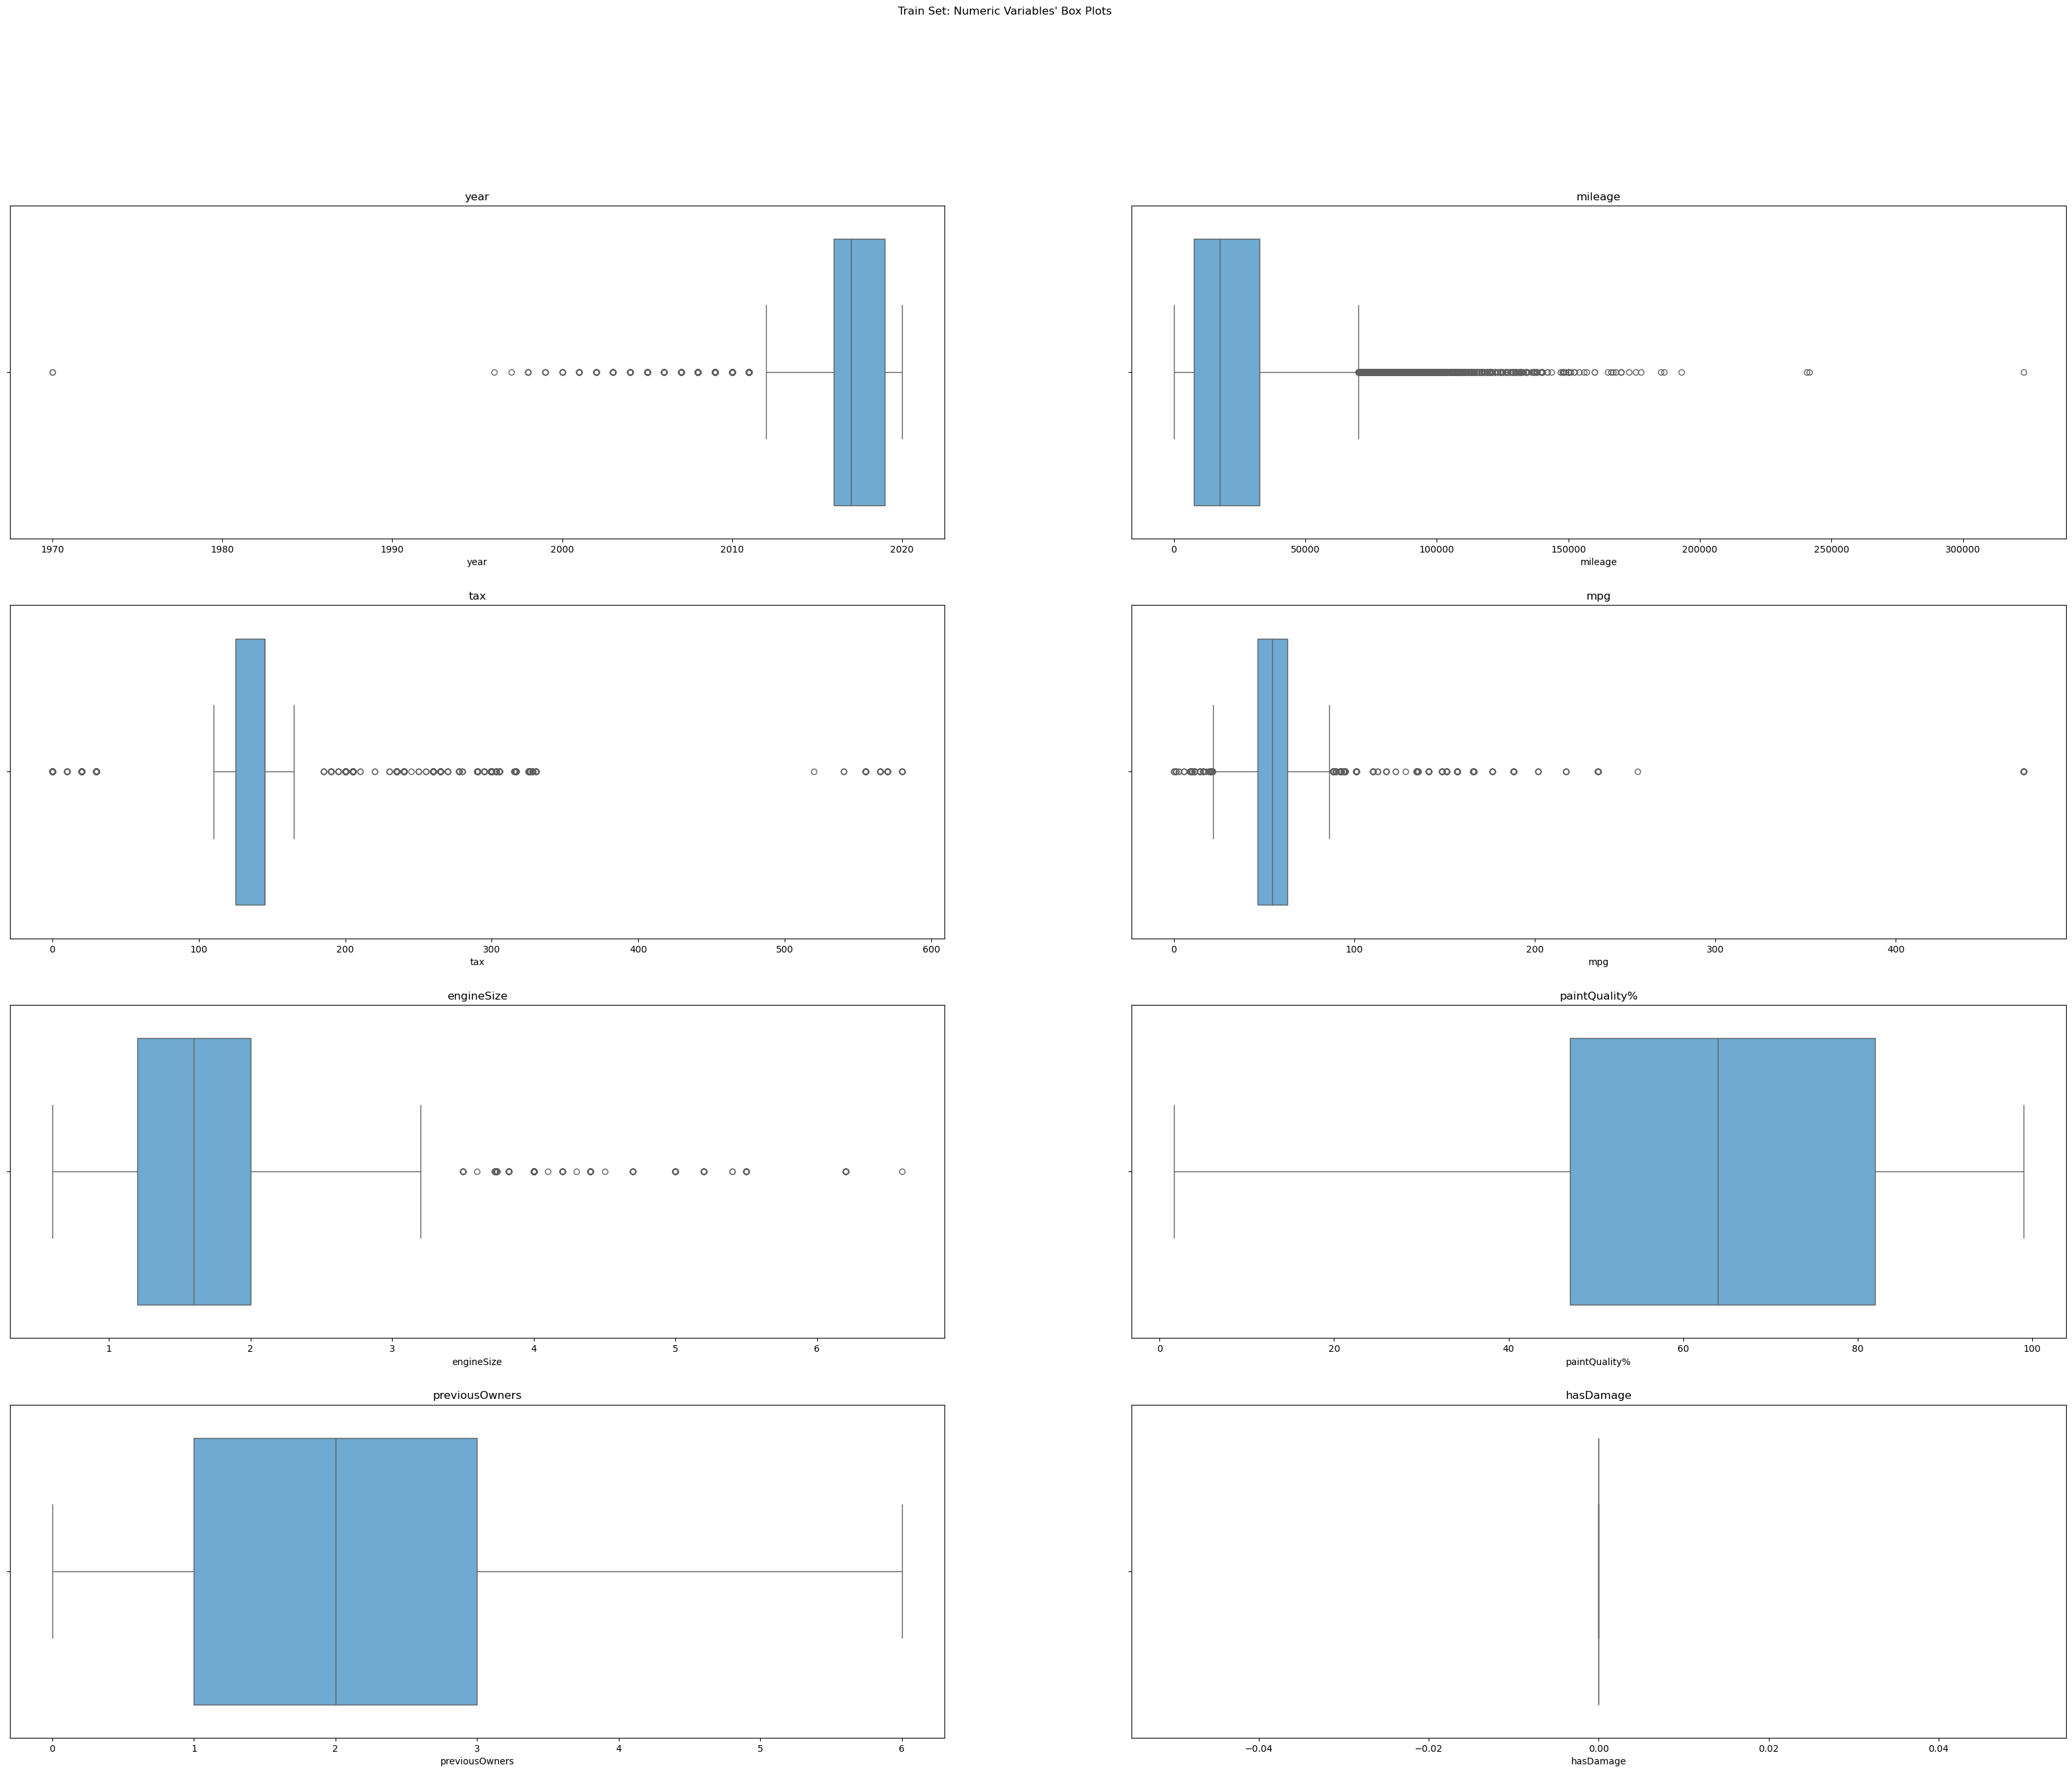

In [68]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_train, metric_features, title="Train Set: Numeric Variables' Box Plots")

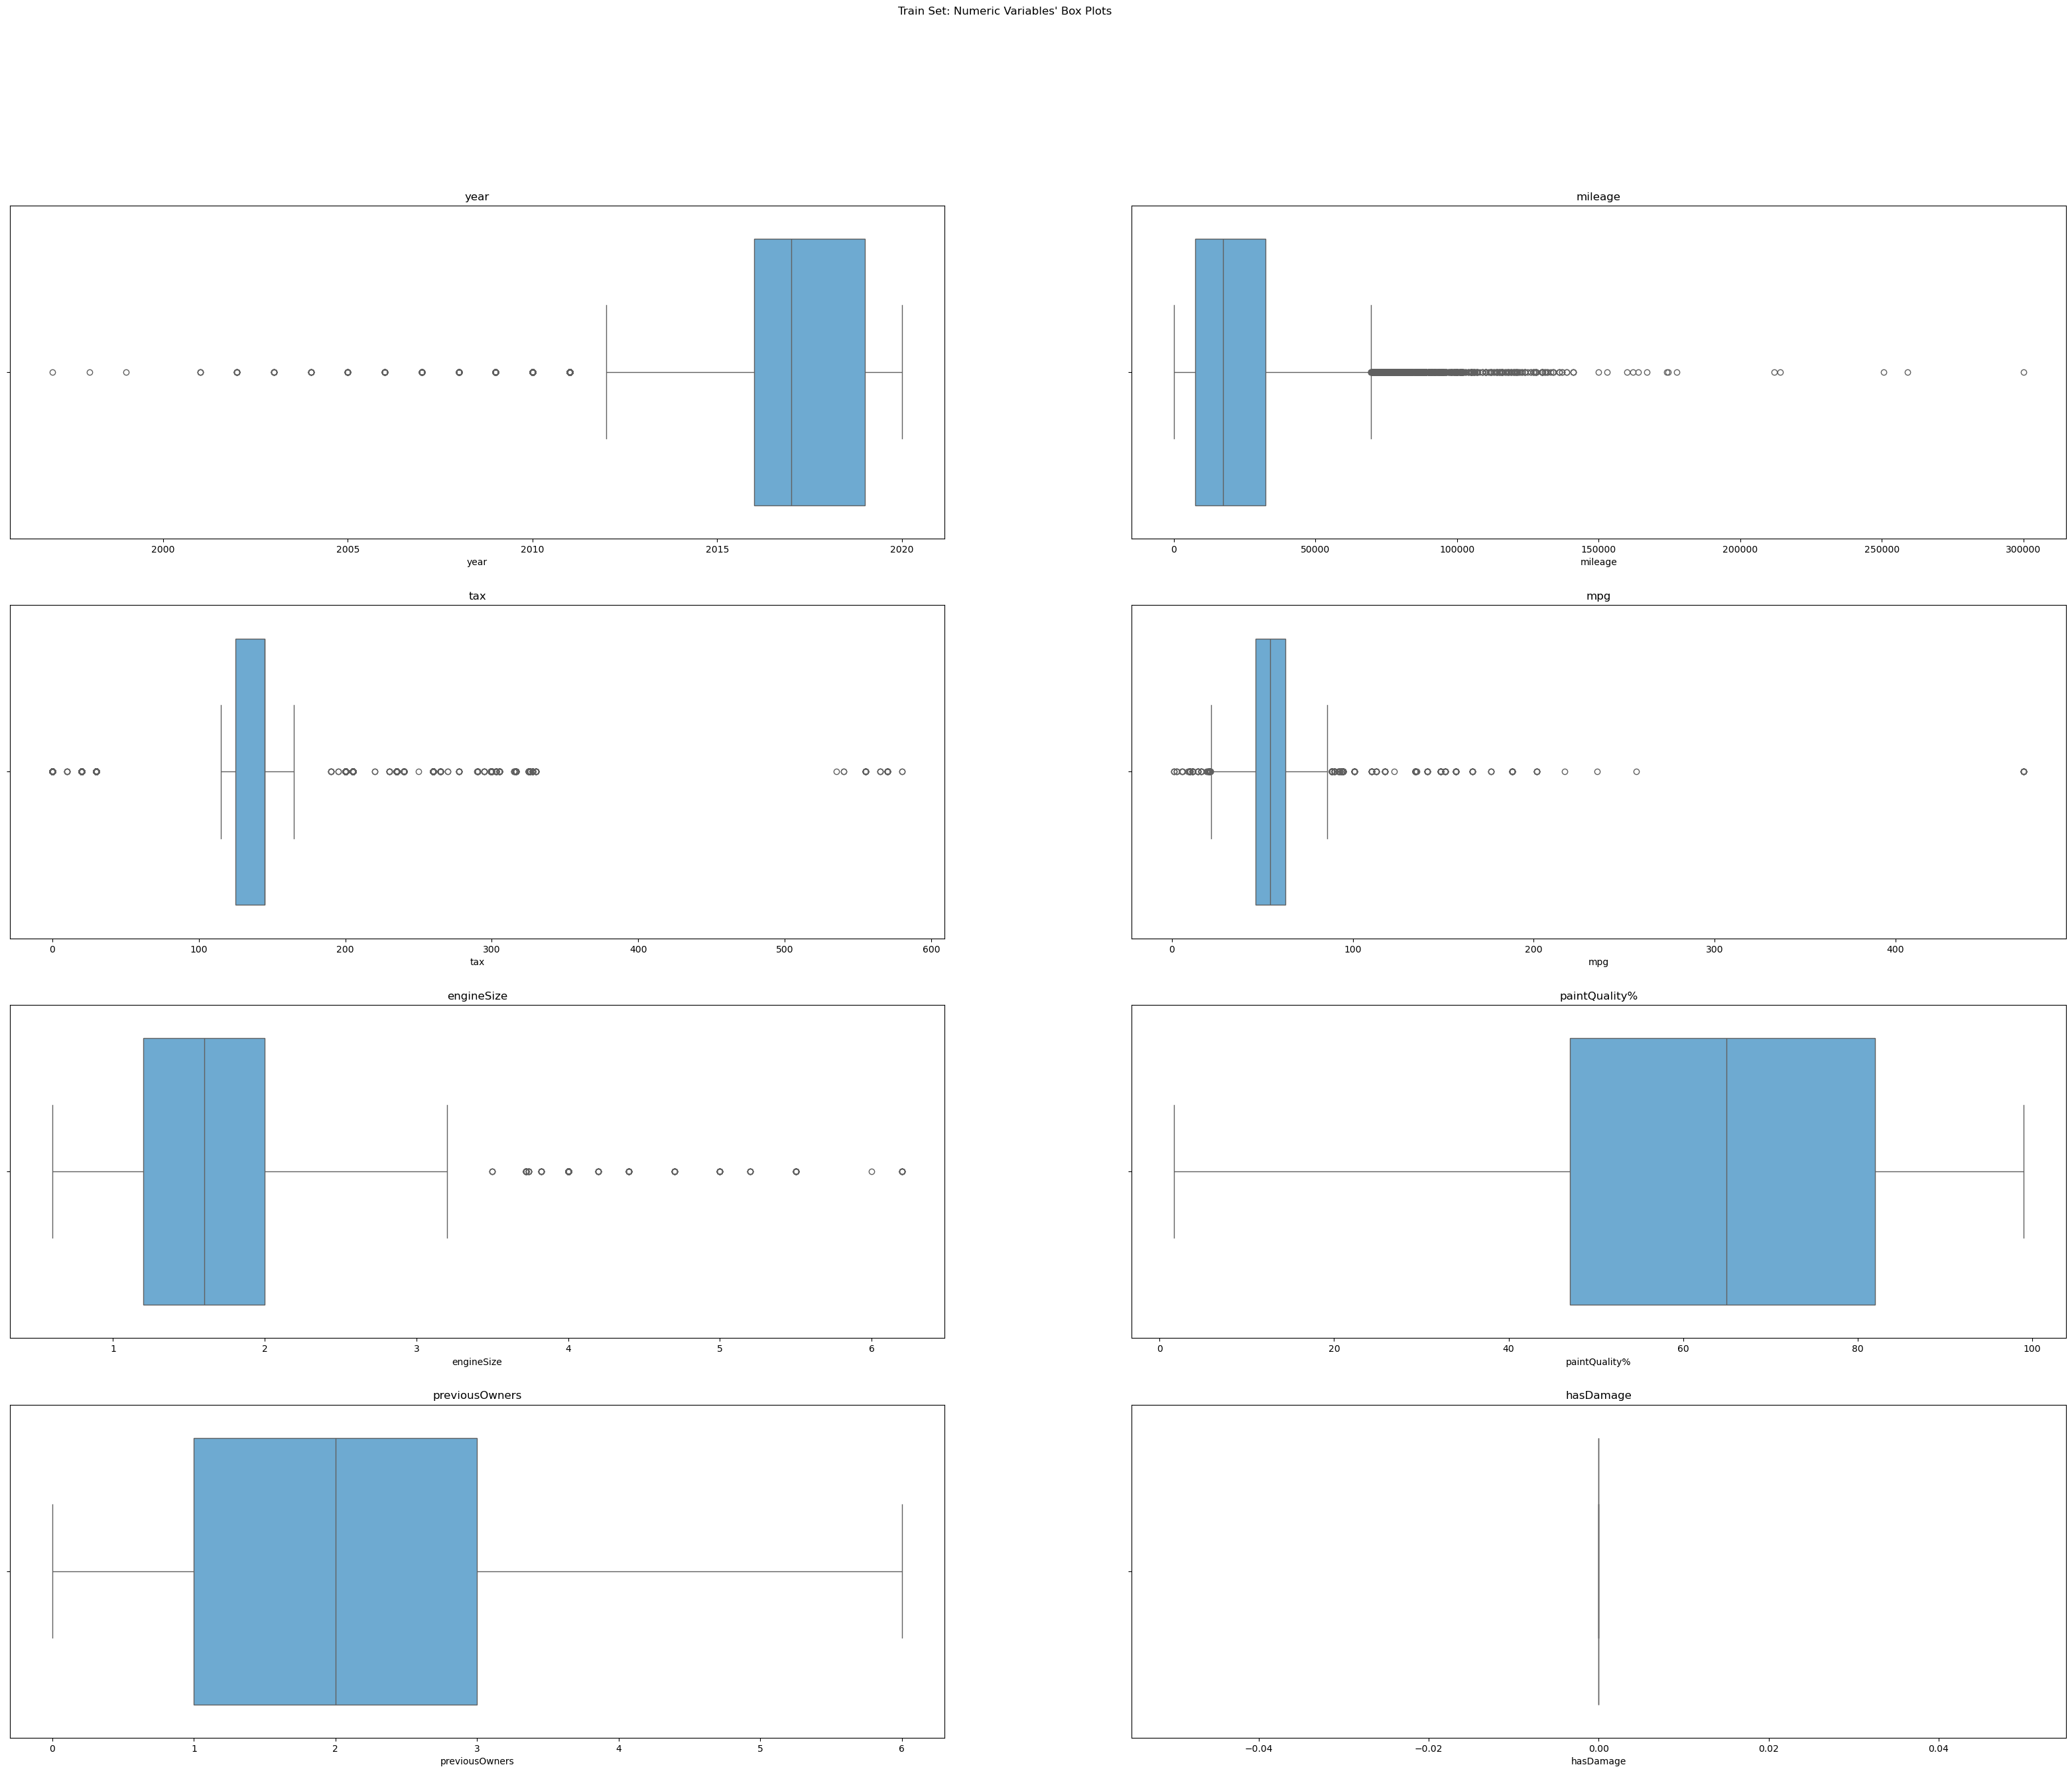

In [69]:
#checking outliers again after handling incoherencies on X_train
plot_multiple_boxplots(X_val, metric_features, title="Train Set: Numeric Variables' Box Plots")

**Year**

In [70]:
'''# Cap year: replacing all numbers below 1995 by 1995
df["year"] = df["year"].clip(lower=1995, upper=2020)

_IncompleteInputError: incomplete input (3578649109.py, line 1)

In [71]:
# Creating a df of observations where year >= 1995
X_train_year= X_train[X_train['year'] >= 1995]
X_val_year= X_val[X_val['year'] >= 1995]

In [72]:
# Checking the percentage of data that would be kept after removing outliers
print('Percentage of data kept after removing outliers:')
print(np.round(X_train_year.shape[0] / X_train.shape[0], 4))
print(np.round(X_val_year.shape[0] / X_val.shape[0], 4))

Percentage of data kept after removing outliers:
0.9755
0.976


In [73]:
# Removing from the datasets
X_train= X_train[X_train['year'] >= 1995]
X_val= X_val[X_val['year'] >= 1995]

**Milage**

In [74]:
X_train[X_train['mileage'] > 150000]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
58385,Opel,Astra,2008,Manual,186500.0,Petrol,260.0,36.7,1.8,54.0,1,0
45553,Mercedes,C Class,2012,Automatic,170000.0,Diesel,145.0,54.3,2.1,64.0,4,0
7038,Audi,A3,2009,Manual,152034.0,Diesel,150.0,55.4,1.9,33.0,4,0
19562,Ford,Focus,2003,Manual,177644.0,Petrol,200.0,41.5,1.6,53.0,2,0
45795,Mercedes,C Class,2008,Automatic,170000.0,Diesel,NaN,NaN,2.1,67.0,3,0
67297,VW,Golf,2009,Manual,193000.0,Diesel,160.0,52.3,2.0,62.0,3,0
41580,Mercedes,C Class,2012,Automatic,170000.0,Diesel,NaN,NaN,2.1,49.0,2,0
4692,Audi,A6,2008,Manual,323000.0,Diesel,200.0,44.1,2.0,74.0,1,0
12289,BMW,3 Series,2010,Manual,156800.0,Diesel,125.0,58.9,2.0,49.0,4,0


In [75]:
# Cap milage: replacing all numbers above 150000 by 150000
X_train["mileage"] = X_train["mileage"].clip(lower=0, upper=150000)
X_val["mileage"] = X_val["mileage"].clip(lower=0, upper=150000)

In [ ]:
'''# Creating a df of observations where milage < 150000
X_train_mil= X_train[X_train['mileage'] < 150000]
X_val_mil= X_val[X_val['mileage'] < 150000]

In [ ]:
'''# Checking the percentage of data that would be kept after removing outliers
print('Percentage of data kept after removing outliers:')
print(np.round(X_train_mil.shape[0] / X_train.shape[0], 4))
print(np.round(X_val_mil.shape[0] / X_val.shape[0], 4))

In [ ]:
''' Removing from the datasets
X_train= X_train[X_train['mileage'] < 150000]
X_val= X_val[X_val['mileage'] < 150000]

**Tax**

In [76]:
X_train[X_train['tax'] < 50]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
74356,VW,Golf,2016,Semi-Auto,19432.0,Diesel,30.0,62.80000,2.0,69.0,3,0
75498,VW,Polo,2016,Semi-Auto,8695.0,Petrol,20.0,60.10000,1.2,61.0,2,0
51358,Toyota,Yaris,2017,Automatic,32994.0,Petrol,30.0,55.00000,1.3,65.0,2,0
2043,Audi,A1,2016,Semi-Auto,33435.0,Petrol,30.0,70.60000,1.4,49.0,0,0
166,Audi,A5,2014,Manual,30884.0,Diesel,30.0,60.10000,2.0,68.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28583,Ford,B-MAX,2013,Manual,37058.0,NaN,30.0,27.70949,1.0,77.0,3,0
31202,Ford,Focus,2017,Manual,13000.0,Petrol,20.0,61.40000,1.0,82.0,4,0
2492,Audi,A4,2016,Automatic,28325.0,Diesel,0.0,72.40000,2.0,48.0,3,0


In [77]:
#the same as 400
X_train[X_train['tax'] > 350]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
41531,Mercedes,SL CLASS,2016,Automatic,6200.0,Petrol,555.0,28.0,5.5,79.0,4,<NA>
44516,Mercedes,SL CLASS,2010,Automatic,79000.0,Petrol,555.0,29.1,3.5,47.0,4,0
54636,Toyota,Land Cruiser,2006,Automatic,113000.0,Diesel,555.0,31.4,3.0,91.0,0,0
37494,Mercedes,M Class,2010,Automatic,128000.0,Diesel,555.0,32.5,3.0,64.0,1,0
52900,Toyota,Land Cruiser,2014,Automatic,60000.0,Diesel,540.0,29.7,4.5,69.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2116,Audi,RS6,2014,Automatic,59894.0,Petrol,555.0,28.8,NaN,68.0,4,0
56446,Opel,Antara,2007,Automatic,99500.0,Diesel,565.0,32.8,2.0,87.0,3,0
35606,Mercedes,M Class,2009,Automatic,59000.0,Diesel,555.0,30.4,3.0,67.0,2,0


- Since the number of cars with *tax* less tahn 100 is large, these we will not be changed.

In [78]:
# Cap tax: replacing all numbers above 350 by 350
X_train["tax"] = X_train["tax"].clip(lower=0, upper=350)
X_val["tax"] = X_val["tax"].clip(lower=0, upper=350)

In [ ]:
'''# Creating a df of observations where tax < 600
X_train_tax= X_train[X_train['tax'] < 600]
X_val_tax= X_val[X_val['tax'] < 600]

In [ ]:
'''# Checking the percentage of data that would be kept after removing outliers
print('Percentage of data kept after removing outliers:')
print(np.round(X_train_tax.shape[0] / X_train.shape[0], 4))
print(np.round(X_val_tax.shape[0] / X_val.shape[0], 4))

- Since the outliers constitute more than 3% of the data, they will not be removed

**Mpg**

In [79]:
X_train[X_train['mpg'] > 300]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
11068,BMW,I3,2016,NaN,43695.0,Hybrid,0.0,470.8,NaN,81.0,1,0
14531,BMW,I3,2017,Automatic,36429.0,Hybrid,0.0,470.8,NaN,30.0,2,0
12332,BMW,I3,2015,Automatic,65800.0,Hybrid,0.0,470.8,NaN,50.0,3,0
9643,BMW,I3,2017,Automatic,20929.0,Hybrid,135.0,470.8,NaN,71.0,2,0
12640,BMW,I3,2017,Automatic,23956.0,NaN,135.0,470.8,0.6,53.0,1,0
12269,BMW,I3,2017,Automatic,26965.0,Hybrid,140.0,470.8,NaN,81.0,3,0
13378,BMW,I3,2015,Automatic,9886.0,Hybrid,0.0,470.8,NaN,44.0,0,0
11962,BMW,I3,2017,Automatic,21025.0,Hybrid,0.0,470.8,NaN,66.0,0,0
10327,BMW,I3,2014,Automatic,42479.0,Hybrid,0.0,470.8,NaN,79.0,2,0


- All mpg > 300 are from BMW I3 and they all have the same mpg.

In [80]:
# Cap mpg: replacing all numbers above 300 by 300
X_train["mpg"] = X_train["mpg"].clip(lower=0, upper=300)
X_val["mpg"] = X_val["mpg"].clip(lower=0, upper=300)

In [ ]:
'''# Creating a df of observations where mpg < 500
X_train_mpg= X_train[X_train['mpg'] < 500]
X_val_mpg= X_val[X_val['mpg'] < 500]

In [ ]:
'''# Checking the percentage of data that would be kept after removing outliers
print('Percentage of data kept after removing outliers:')
print(np.round(X_train_mpg.shape[0] / X_train.shape[0], 4))
print(np.round(X_val_mpg.shape[0] / X_val.shape[0], 4))

- Since the outliers constitute more than 3% of the data, they will not be removed

**EngineSize**

In [81]:
X_train[X_train['engineSize'] > 5]

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,
41531,Mercedes,SL CLASS,2016,Automatic,6200.0,Petrol,350.0,28.0,5.5,79.0,4,<NA>
2487,Audi,R8,2019,Semi-Auto,7800.0,Petrol,145.0,21.4,5.2,72.0,4,0
45626,Mercedes,SL CLASS,2016,Semi-Auto,21681.0,Petrol,350.0,28.0,5.5,71.0,1,0
37895,Mercedes,GLE Class,2019,Semi-Auto,11545.0,Petrol,145.0,23.9,5.5,NaN,2,0
35290,Mercedes,C Class,2014,Automatic,56444.0,Petrol,350.0,23.5,6.2,65.0,0,0
39752,Mercedes,C Class,2014,Automatic,56444.0,Petrol,NaN,NaN,6.2,52.0,3,0
2022,Audi,R8,2019,Automatic,8175.0,Petrol,145.0,21.6,5.2,47.0,4,0
40976,Mercedes,GLE Class,2019,Semi-Auto,9.0,Petrol,145.0,23.7,5.5,NaN,1,0
46064,Mercedes,GLE Class,2017,Semi-Auto,6000.0,Petrol,145.0,23.9,5.5,92.0,3,0


In [82]:
# Cap engineSize: replacing all numbers above 5 by 5
X_train["engineSize"] = X_train["engineSize"].clip(lower=0, upper=5)
X_val["engineSize"] = X_val["engineSize"].clip(lower=0, upper=5)

In [ ]:
'''# Creating a df of observations where engineSize < 5
X_train_eng= X_train[X_train['engineSize'] < 5]
X_val_eng= X_val[X_val['engineSize'] < 5]

In [ ]:
'''# Checking the percentage of data that would be kept after removing outliers
print('Percentage of data kept after removing outliers:')
print(np.round(X_train_eng.shape[0] / X_train.shape[0], 4))
print(np.round(X_val_eng.shape[0] / X_val.shape[0], 4))

In [ ]:
'''# Removing from the datasets
X_train= X_train[X_train['engineSize'] < 5]
X_val= X_val[X_val['engineSize'] < 5]

### 4.7. Treating Missing Values

#### 4.7.1. Numerical Variables 

**KNN Imputer**

In [83]:
X_train[metric_features].isna().sum().sort_values(ascending=False)

tax               5609
mpg               5385
engineSize        1414
paintQuality%     1316
mileage           1243
hasDamage         1072
previousOwners    1069
year                 0
dtype: int64

In [84]:
X_val[metric_features].isna().sum().sort_values(ascending=False)

tax               2458
mpg               2373
engineSize         574
mileage            550
paintQuality%      527
hasDamage          445
previousOwners     443
year                 0
dtype: int64

- Most of our variables are MAR (missing at random), which means that missingness depends on known variables. For example, we can imply that milage depends on brand, year and engine size; mpg depends on fuel type and model; tax depends on fuel type and year, etc.
- This means that the "correct" value for a missing record would not reply on the global mean, but depends on similiar cars. Therefore, the KNN imputer method is a good solution for this type of problem since it is capable of dealing with MAR, while capturing non linear relationships. 

In [85]:
#scalling X_train and X_val since KNN imputer uses distances

#numerical variables whose missing values need to be filled
numeric_cols = ['tax', 'mpg', 'mileage', 'paintQuality%', 'engineSize', 'hasDamage', 'previousOwners']
scaler = MinMaxScaler()

# fitting the scaler only on training dataset (to avoid leakage)
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# transforming validation dataset using the same scaling
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

In [86]:
knn = KNNImputer(n_neighbors=5, weights='distance')

X_train[numeric_cols] = knn.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = knn.transform(X_val[numeric_cols])

In [87]:
X_train[metric_features].isna().sum().sort_values(ascending=False)

year              0
mileage           0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64

In [88]:
X_val[metric_features].isna().sum().sort_values(ascending=False)

year              0
mileage           0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64

#### 4.7.2. Categorical Variables

**Filling with the mode**

In [89]:
X_train[non_metric_features].isna().sum().sort_values(ascending=False)

transmission    1604
model           1153
fuelType        1110
Brand           1019
dtype: int64

In [90]:
X_val[non_metric_features].isna().sum().sort_values(ascending=False)

transmission    614
fuelType        520
model           507
Brand           460
dtype: int64

In [91]:
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train.loc[:, non_metric_features] = cat_imputer.fit_transform(X_train[non_metric_features])
X_val.loc[:, non_metric_features] = cat_imputer.transform(X_val[non_metric_features])

In [92]:
X_train[non_metric_features].isna().sum().sort_values(ascending=False)

Brand           0
model           0
transmission    0
fuelType        0
dtype: int64

In [93]:
X_val[non_metric_features].isna().sum().sort_values(ascending=False)

Brand           0
model           0
transmission    0
fuelType        0
dtype: int64

### 4.8. Feature Engineering

#### 4.8.1. Creating New Variables

In [94]:
X_train['engineEfficiency'] = X_train['mpg'] / X_train['engineSize']
X_val['engineEfficiency'] = X_val['mpg'] / X_val['engineSize']

#### 4.8.2. Encoding Categorical Features

- Frequency encoding is used to transform the variables Brand and model into numerical, as these have a high cardinality, while transmission and fuelType was transformed into dummy variables.

In [95]:
freq_encoding_brand = X_train['Brand'].value_counts()
X_train['brand_encoded'] = X_train['Brand'].map(freq_encoding_brand)
X_val['brand_encoded'] = X_val['Brand'].map(freq_encoding_brand)

In [96]:
freq_encoding_model = X_train['model'].value_counts()
X_train['model_encoded'] = X_train['model'].map(freq_encoding_model)
X_val['model_encoded'] = X_val['model'].map(freq_encoding_model)

In [97]:
X_train = pd.get_dummies(X_train, columns=['transmission'], prefix='Transmission', drop_first=True)
X_val = pd.get_dummies(X_val, columns=['transmission'], prefix='Transmission', drop_first=True)

- We observed that the fuelType variable contained, only 4 Electric cars, which is an extremely low representation for a category, and 46 rows defined as "other". To prevent overfitting and unstable coefficients, these categories were grouped together into the Other class.

In [98]:
print(X_train["fuelType"].value_counts())
print(X_val["fuelType"].value_counts())

fuelType
Petrol      29263
Diesel      21085
Hybrid       1519
Electric        3
Name: count, dtype: int64
fuelType
Petrol    12536
Diesel     9035
Hybrid      670
Name: count, dtype: int64


In [99]:
rare_fuels = ['Electric', 'Other']
X_train['fuelType'] = X_train['fuelType'].replace(rare_fuels, 'Other')
X_val['fuelType'] = X_val['fuelType'].replace(rare_fuels, 'Other')

X_train = pd.get_dummies(X_train, columns=['fuelType'], prefix='Fuel', drop_first=True)
X_val = pd.get_dummies(X_val, columns=['fuelType'], prefix='Fuel', drop_first=True)

In [100]:
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
#ensures that X_train and X_val have the same colums to avoid mismatch

bool_cols = X_train.select_dtypes(include=['bool', 'int8']).columns
#bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_val[bool_cols] = X_val[bool_cols].astype(int)

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51870 entries, 42520 to 15659
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   51870 non-null  object 
 1   model                   51870 non-null  object 
 2   year                    51870 non-null  Int32  
 3   mileage                 51870 non-null  float64
 4   tax                     51870 non-null  float64
 5   mpg                     51870 non-null  float64
 6   engineSize              51870 non-null  float64
 7   paintQuality%           51870 non-null  float64
 8   previousOwners          51870 non-null  float64
 9   hasDamage               51870 non-null  float64
 10  engineEfficiency        51870 non-null  float64
 11  brand_encoded           51870 non-null  int64  
 12  model_encoded           51870 non-null  int64  
 13  Transmission_Manual     51870 non-null  int64  
 14  Transmission_Semi-Auto  51870 non-null 

In [102]:
X_val.isna().sum().sort_values(ascending=False)

model_encoded             4
Brand                     0
model                     0
year                      0
tax                       0
mileage                   0
engineSize                0
paintQuality%             0
previousOwners            0
mpg                       0
hasDamage                 0
engineEfficiency          0
brand_encoded             0
Transmission_Manual       0
Transmission_Semi-Auto    0
Fuel_Hybrid               0
Fuel_Other                0
Fuel_Petrol               0
dtype: int64

In [103]:
mean_freq = freq_encoding_model.mean()
X_val['model_encoded'] = X_val['model'].map(freq_encoding_model).fillna(mean_freq)

In [104]:
X_val.isna().sum().sort_values(ascending=False)

Brand                     0
model                     0
year                      0
mileage                   0
tax                       0
mpg                       0
engineSize                0
paintQuality%             0
previousOwners            0
hasDamage                 0
engineEfficiency          0
brand_encoded             0
model_encoded             0
Transmission_Manual       0
Transmission_Semi-Auto    0
Fuel_Hybrid               0
Fuel_Other                0
Fuel_Petrol               0
dtype: int64

In [105]:
X_train = X_train.drop(['Brand', 'model'], axis=1)
X_val = X_val.drop(['Brand', 'model'], axis=1)

In [106]:
# ensuring that y_train has the same rows X_train
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (51870, 16)
y_train shape: (51870,)


### 4.9. Scaling

In [107]:
#checking if the variable created has some infinite values
print(np.isinf(X_train["engineEfficiency"]).sum())
print(np.isinf(X_val["engineEfficiency"]).sum())

1
3


In [108]:
#replace infinite by missing values
X_train = X_train.replace({"engineEfficiency": {np.inf: np.nan, -np.inf: np.nan}})
X_val = X_val.replace({"engineEfficiency": {np.inf: np.nan, -np.inf: np.nan}})

In [109]:
#fill the missing values using the mode 
X_train['engineEfficiency'] = cat_imputer.fit_transform(X_train[['engineEfficiency']])
X_val['engineEfficiency'] = cat_imputer.transform(X_val[['engineEfficiency']])

- We replaced the infinites by missing values and fill them because, if there were infinites in *engineEfficiency*, the scaled would not work. 

In [110]:
#variables that are not scalled yet
rest_var = ['year', 'brand_encoded', 'model_encoded', 'engineEfficiency' ]

# fitting the scaler only on training dataset (to avoid leakage)
X_train[rest_var] = scaler.fit_transform(X_train[rest_var])

# transforming validation dataset using the same scaling
X_val[rest_var] = scaler.transform(X_val[rest_var])

In [111]:
#checking if X_train and y_train have the same number of rows
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (51870, 16)
y_train shape: (51870,)


In [112]:
#checking if X_val and y_val have the same number of rows
print("X_val shape:", X_train.shape)
print("y_val shape:", y_train.shape)

X_val shape: (51870, 16)
y_val shape: (51870,)


In [ ]:
'''scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns).set_index(X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns).set_index(X_val.index)

X_train = X_train_scaled
X_val = X_val_scaled

# ensuring that y_train has the same rows X_train
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

### Pre Processing Test Data

#### Dataset Overview

In [ ]:
test_data.info()

In [ ]:
test_data.head(20)

#### Changing Datatypes

In [ ]:
#set index to 'carID'
test_data.set_index('carID', inplace = True)

In [ ]:
# Rounds the floats and changes them to integers

#year to integer
test_data['year'] = test_data['year'].round().astype('Int32')
test_data['year'] = test_data['year'].round().astype('Int32')

#previousOwners to integer
test_data['previousOwners'] = test_data['previousOwners'].round().astype('Int32')
test_data['previousOwners'] = test_data['previousOwners'].round().astype('Int32')

#hasDamaged to boolean
test_data['hasDamage'] = test_data['hasDamage'].astype('Int8')
test_data['hasDamage'] = test_data['hasDamage'].astype('Int8')

#### Handling Incoherencies

In [ ]:
#correcting spelling mistakes of 'brand' for test_data

correct_brand = {
    'VW': ['V', 'vw', 'v', 'W', 'w'],
    'Toyota': ['Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot', 'oyot'],
    'Audi': ['udi', 'AUDI', 'audi', 'Aud', 'aud', 'UDI', 'AUD'],
    'Ford': ['FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    'BMW': ['MW', 'bmw', 'BM', 'mw', 'M', 'bm'],
    'Skoda': ['koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    'Opel': ['Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    'Mercedes': ['mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE'],
    'Hyundai': ['yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'ud', 'hyunda', 'YUNDAI']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_brand.items() for variant in variants}

# Replace incorrect brand names with the correct ones
test_data["Brand"] = test_data["Brand"].replace(replacement_dict)

# Verify the cleaning
print(test_data["Brand"].unique())

In [ ]:
##correcting spelling mistakes of 'model' for test_data

correct_model = {
    'Golf': [' GOLF', ' Gol', ' golf', 'golf', ' Golf', ' gol', ' GOL', 'Gol', 'GOLF'],
    'Yaris': [' Yaris', ' YARIS', ' Yari', ' yaris', ' yari', 'Yari', ' YARI', 'yaris', 'YARIS'],
    'Q2': [' q2', ' Q2'],
    '2 Series': [' 2 series', ' 2 serie', '2 Series', ' 2 SERIES', ' 2 Serie', '2 Serie', ' 2 Series'],
    '3 Series': [' 3 Series', ' 3 Serie', ' 3 series', ' 3 SERIES', ' 3 serie', '3 Serie'],
    'A3': [' A3', ' a3'],
    'Octavia': [' Octavi', ' OCTAVIA', ' Octavia', ' octavia', 'Octavi', 'octavia', ' octavi', ' OCTAVI'],
    'Passat': [' PASSAT', ' passat', ' Passa', 'Passat', ' Passat', 'PASSAT', ' PASSA'],
    'Insignia': [' Insigni', ' INSIGNIA', ' insignia', ' Insignia', ' INSIGNI', 'Insigni'],
    'Fabia': [' Fabia', ' fabia', ' FABIA', ' Fabi', 'FABIA'],
    'A Class': [' A Clas', ' A Class', ' a class', ' A CLASS', 'a class', 'A CLASS', ' a clas'],
    'Ka+': [' Ka+', ' KA+', ' ka+', 'ka+'],
    'GLC Class': [' GLC Class', ' GLC CLASS', ' GLC Clas', ' glc class', ' glc clas'], 
    'I30': [' i30', ' I30'],
    'C Class': [' C Clas', ' C CLASS', ' c class', 'C Clas', ' C CLAS', 'c class', ' c clas', ' C Class', 'C CLASS'],
    'Polo': [' POLO', ' Polo', ' polo', ' Pol', ' POL', 'Pol', 'POLO'],
    'E Class': [' E Class', ' E Clas', ' E CLASS', ' e class', 'E CLASS', 'e class'],
    'Q5': [' Q5', ' q5', 'q5'],
    'Up': ['U', ' up', ' UP', ' Up', ' U', 'UP'],
    'Fiesta': [' FIESTA', ' fiesta', ' Fiest', ' Fiesta', 'fiesta', 'Fiest', ' FIESTA', 'FIESTA', ' fiest'],
    'C-HR': [' C-H', ' c-hr', ' C-HR', ' c-h'],
    'Mokka X': [' mokka x', ' MOKKA X', ' Mokka X'],
    'Corsa': [' Corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', 'corsa'],
    'Astra': [' ASTRA', ' Astr', ' Astra', ' astra', 'ASTRA', 'astra'],
    'TT': [' tt', ' TT', ' T'],
    '5 Series': [' 5 Series', ' 5 Serie', ' 5 SERIES', ' 5 series', '5 SERIES', ' 5 SERIE'],
    'Aygo': [' aygo', ' ayg', ' AYGO', ' Ayg', ' Aygo', 'aygo', ' AYG'],
    '4 Series': [' 4 SERIES', ' 4 Serie', ' 4 serie', '4 series', '4 Series', ' 4 Series', ' 4 series'],
    'SLK': [' slk', ' SLK'],
    'Viva': [' viva', ' Viva', ' VIVA', ' Viv', 'viva'],
    'Focus': [' Focus', ' Focu', ' FOCUS', ' focus', ' FOCU', 'focus', 'Focu', ' focu', 'FOCUS'],
    'EcoSport': [' EcoSpor', ' ECOSPORT', ' ecosport', ' EcoSport'],
    'X-CLASS': [' x-clas', ' X-CLAS', ' x-class', ' X-CLASS'],
    'CL Class': [' cl class', ' CL Clas', ' CL CLASS', ' CL Class'],
    'IX20': [' ix20', ' IX20'],
    'Rapid': [' Rapi', ' rapid', ' Rapid'],
    'Auris': [' Auris', ' AURIS', ' auris', ' Auri'],
    'I20': [' i20', ' I20'],
    'X3': [' x3', ' X3'],
    'A8': [' A8', 'a8'],
    'GLS Class': [' GLS Clas', ' GLS CLASS', ' gls class', ' GLS Class'],
    'B-MAX': [' B-MA', ' B-MAX', 'B-MA', ' b-max'],
    'A4': [' A4', ' a4'],
    'Kona': [' KONA', ' Kon', ' Kona', ' KON', ' kona'],
    'I10': [' i10', ' I10'],
    'A1': [' A1', ' a1'],
    'Mokka': [' Mokka ', ' Mokk', ' Mokka', ' mokka ', ' mokka', ' MOKKA', 'Mokka ', 'Mokk'],
    'S-MAX': [' S-MA', ' s-max', ' S-MAX', ' s-ma'],
    'X2': [' x2', ' X2'],
    'Crossland X': [' crossland x', ' CROSSLAND X', ' Crossland X'],
    'Tiguan': [' Tiguan', ' tiguan', ' Tigua', ' TIGUAN', ' TIGUA', 'Tigua', 'TIGUAN', 'tiguan', ' tigua'],
    'A5': [' A5', ' a5', 'a5'],
    'GLE Class': [' GLE Clas', ' GLE Class', ' gle class', ' GLE CLASS'],
    'Zafira': [' Zafira', ' Zafir', ' ZAFIRA', ' zafira', 'Zafir', ' ZAFIR'],
    'Ioniq': [' Ioni', ' Ioniq', ' IONIQ', 'IONIQ', ' ioniq'],
    'A6': [' A6', ' a6'],
    'Yeti Outdoor': [' yeti outdoor', ' Yeti Outdoor', ' YETI OUTDOOR', ' Yeti Outdoo', ' yeti outdoor', 'yeti outdoor', ' yeti outdoo'],
    'X1': [' x1', 'x1', ' X1'],
    'Scala': [' SCALA', ' Scala', ' scala', ' Scal', ' scal'],
    'S Class': [' S Class', ' S Clas', ' s class', ' S CLASS'],
    '1 Series': [' 1 Series', ' 1 SERIES', ' 1 Serie', ' 1 series', '1 SERIES', ' 1 SERIE', '1 series', ' 1 serie'],
    'Kamiq': [' KAMIQ', ' KAMI', ' kamiq', ' Kamiq'],
    'Kuga': [' Kug', ' KUGA', ' kuga', 'Kuga', ' Kuga', 'kuga'],
    'Tourneo Connect': [' tourneo connect', ' Tourneo Connect'],
    'Q7': [' q7', ' Q7'],
    'GLA Class': [' GLA Class', ' GLA CLASS', ' GLA Clas', ' gla class'],
    'Arteon': [' arteon', ' Arteon', ' Arteon'],
    'SL CLASS': [' SL CLAS', ' SL CLASS', ' sl class', ' SL'],
    'Tucson': [' Tucson', ' TUCSON', ' Tucso', ' tucson', ' TUCSO', 'Tucso'],
    'Santa Fe': [' Santa F', ' santa fe', ' SANTA FE', ' Santa Fe'],
    'Grandland X': [' Grandland X', ' grandland x', ' GRANDLAND X'],
    'RAV4': [' rav4', 'RAV4', 'RAV', ' RAV', 'rav4', ' rav', ' RAV4'],
    'Touran': [' Touran', 'Toura', ' TOURAN', ' touran', ' Toura', ' TOURA'],
    'Citigo': [' Citig', ' citigo', ' Citigo', ' CITIGO', 'CITIGO'],
    'Roomster': [' Roomste', ' Roomster'],
    'Prius': [' PRIUS', ' Prius', 'Prius', ' prius'],
    'Corolla': [' corolla', ' COROLLA', ' Coroll', ' Corolla', 'corolla'],
    'B Class': [' b class', ' B Clas', ' B Class', ' B CLASS', 'b class'],
    'Sharan': [' sharan', ' Shara', ' Sharan', ' SHARAN'],
    'Kodiaq': [' Kodia', ' kodiaq', 'kodiaq', ' KODIAQ', ' Kodiaq'],
    'V Class': [' V Clas', ' V CLASS', ' V Class', ' v class'],
    'Caddy Maxi Life': [' Caddy Maxi Lif', ' Caddy Maxi Life'],
    'Superb': [' Superb', ' Super', ' SUPERB', ' superb', ' super'],
    'T-Roc': [' T-Roc', ' T-RO', ' t-roc', ' T-Ro', ' T-ROC'],
    'Combo Life': [' COMBO LIFE', ' combo life', ' Combo Lif', 'COMBO LIFE', ' Combo Life'],
    'Beetle': [' Beetl', ' Beetle', ' beetle'],
    'Galaxy': [' GALAXY', ' Galax', ' galaxy', ' Galaxy'],
    'M3': [' M3', ' m3'],
    'Gtc': [' gtc', ' GTC', ' gtc', 'gtc', 'GTC'],
    'X4': [' X4', ' x4'],
    'KA': [' Ka', ' ka', ' K', ' KA'],
    'IX35': [' ix35', ' IX35'],
    'Grand Tourneo Connect': [' Grand Tourneo Connec', ' Grand Tourneo Connect'],
    'M4': [' m4', ' M4'],
    'Tourneo Custom': [' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    'Z4': [' Z4', ' z4'],
    'X5': [' X5', ' x5'],
    'Meriva': [' Meriva', ' MERIVA', ' Meriv', ' meriva'],
    'RS6': [' RS6'],
    'Verso': [' VERSO', ' verso', ' Verso', ' Vers'],
    'Touareg': [' Touareg', ' TOUAREG', ' touareg', ' Touare'],
    'Mondeo': [' MONDEO', ' Mondeo', ' mondeo', ' MONDE', ' Monde'],
    'Shuttle': [' shuttle', ' Shuttle', ' SHUTTLE'],
    'CLS Class': [' CLS Class', ' cls class', ' CLS Clas', ' CLS CLASS'], 
    'C-MAX': [' C-MAX', ' c-max', ' C-MA'],
    'Puma': [' puma', ' PUMA', ' Puma', 'Pum', ' Pum'],
    'CLA Class': [' CLA Class', ' CLA CLASS', ' cla class', ' CLA Clas'],
    'I40': [' I40', ' i40'],
    'Q3': [' q3', ' Q3'],
    'Tiguan Allspace': [' TIGUAN ALLSPACE', ' tiguan allspace', ' Tiguan Allspac', ' Tiguan Allspace'],
    '6 Series': [' 6 SERIES', ' 6 series', ' 6 Series', ' 6 Serie'],
    'Caravelle': [' caravelle', ' Caravell', ' Caravelle'],
    'Karoq': [' Karoq', ' karoq', ' KAROQ', ' Karo'],
    'I3': [' i3', 'i3', ' I3'],
    'Grand C-MAX': [' GRAND C-MAX', ' grand c-max', ' Grand C-MA', ' Grand C-MAX'],
    'T-Cross': [' T-Cros', ' T-CROSS', ' T-Cross', ' t-cros', ' t-cross'],
    'A7': [' a7', ' A7'],
    'Golf SV': [' Golf SV', ' golf sv', ' GOLF SV'],
    'A': [' a', ' A'],
    'GT86': [' gt86', ' GT86'],
    'Yeti': [' yeti', ' Yet', ' Yeti', ' YETI'],
    'X': [' x', ' X'],
    'Land Cruiser': [' Land Cruise', ' Land Cruiser', ' land cruiser'],
    'EDGE': [' Edge', ' edge', ' Edg', ' EDGE'],
    'X6': [' X6'],
    'Fusion': [' Fusion', ' fusion'],
    'GL Class': [' GL CLASS', ' gl class', ' GL Class', ' GL Clas'],
    'Scirocco': [' scirocco', ' SCIROCCO', ' Scirocc', ' Scirocco'],
    'Z3': [' Z3'],
    'Hilux': [' hilux', ' Hilux', ' Hilu', ' HILU'],
    'Amarok': [' amarok', ' Amarok', ' Amaro'],
    'CC': [' cc', ' CC'],
    '7 Series': [' 7 Serie', ' 7 SERIES', ' 7 series', ' 7 Series'],
    'Avensis': [' AVENSIS', ' avensis', ' Avensis'],
    'M Class': [' m class', ' M CLASS', ' M Class', ' M Clas', ' M CLAS'],
    'Grandland': [' grandland ', ' Grandland '],
    'Zafira Tourer': [' Zafira Toure', ' ZAFIRA TOURER', ' Zafira Tourer', ' zafira tourer'],
    'R8': [' R8', ' r8'],
    'Mustang': [' mustang', ' Mustang'],
    'Q8': [' Q8'],
    'CLK': [' CLK'],
    'RS3': [' RS3'],
    'Jetta': [' JETTA', ' Jetta', ' jetta', 'Jetta' ],
    'Supra': [' Supra'],
    'X7': [' X7'],
    'SQ7': [' SQ7', ' sq7'],
    'S3': [' s3', ' S3'],
    'Arteon': [' Arteo', 'Arteo', ' ARTEON', ' arteon', ' Arteon'],
    'GLB Class': [' glb class', ' GLB Class'],
    'Adam': [' Ada', ' adam', ' ADAM', ' Adam'],
    'M5': [' M5',' m5'],
    'Golf S': [' golf s', ' Golf S'],
    'Vectra': ['Vectra', ' Vectra', ' VECTRA', 'VECTRA'],
    '8 Series': [' 8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    'Urban Cruiser': [' Urban Cruise', ' Urban Cruiser'],
    'Fox': ['fox', ' fox', ' Fox'], 
    'Q': [' Q'], 
    'M2': [' M2'], 
    'RS4':[' RS4'], 
    'Veloster': [' Veloster', ' Veloste'],  
    'IQ': [' IQ'], 
    'Agila': [' AGILA', ' Agila'], 
    'I2': [' I2'], 
    'Antara': [' Antara', ' antara'], 
    'G Class': [' G Class', ' G CLAS'], 
    'Caddy Life': [' Caddy Life', ' Caddy'],
    'R Class': [' R Class'], 
    'I800': [' I800'],
    'Amica': [' Amica'], 
    'Crossland': [' Crossland '],
    'Proace Verso': [' proace verso', ' PROACE VERSO', 'PROACE VERSO'],
    'Camry': [' Camry', 'Camry', ' Camr'], 
    'Tigra': [' Tigra'], 
    'Eos': [' Eos'], 
    'M': [' M'],
    'California': [' Californi', ' California'], 
    'Ampera': [' Ampera'], 
    'I1': [' I1'], 
    'S5': [' S5'], 
    'CLC Class': [' CLC Class'], 
    'Shara': [' SHARA'], 
    'I8': [' i8', 'i8'], 
    'RS7': [' RS7'], 
    'Transit Tourneo': [' Transit Tourneo'], 
    'I4': [' I4'], 
    'S4':[' S4'], 
    'Terracan': [' Terracan'], 
    'Cascada': [' Cascada'], 
    'S8': [' S8'], 
    'A2':[' A2'], 
    'Vivaro':[' Vivaro'],
    'RS5':[' RS5'],
    'SQ5':[' SQ5'], 
    'Getz':[' Getz'], 
    'M6':[' M6'], 
    'Caddy Maxi': [' Caddy Maxi'], 
    'Z':[' Z'], 
    'Verso-S': [' Verso-S'], 
    'Kadjar': [' Kadjar'], 
    'I80': [' I80'], 
    'Streetka': [' Streetka'],
    'RS': [' RS'], 
    'I': [' i'], 
    'Ranger': [' Ranger'], 
    'IX2': [' IX2'], 
    'Escort': [' Escort'],
    'Accent': [' Accent']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_model.items() for variant in variants}

# Replace incorrect brand names with the correct ones
test_data["model"] = test_data["model"].replace(replacement_dict)

# Verify the cleaning
print(test_data["model"].unique())

In [ ]:
##correcting spelling mistakes of 'transmission' for test_data

correct_transmission = {
    'Semi-Auto': ['Semi-Aut', 'semi-auto', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT', 'EMI-AUTO', 'emi-Aut', 'emi-auto', 'semi-aut'],
    'Manual': ['anual', 'manual', 'Manua', 'MANUAL', ' Manual ', 'ANUAL', 'manua', 'anua', 'MANUA', ' manual ', ' MANUAL ', ' Manual', 'Manual ', 'manual '],
    'Automatic': ['AUTOMATIC', 'automatic', 'Automati', 'utomatic', 'UTOMATIC', 'automati', 'AUTOMATI', 'utomati'],
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_transmission.items() for variant in variants}

# Replace incorrect brand names with the correct ones
test_data["transmission"] = test_data["transmission"].replace(replacement_dict)

#replacing the 'unknown' and 'other' variable with a missing value
test_data["transmission"] = test_data["transmission"].replace(['unknow','UNKNOWN','nknown','nknow', 'unknown', 'Other'], np.nan)

# Verify the cleaning
print(test_data["transmission"].unique())

In [ ]:
##correcting spelling mistakes of 'fuelType' for test_data

correct_fuelType = {
    'Petrol': ['etrol', 'petrol', 'PETROL', 'Petro', 'petro', 'ETROL', 'PETRO', 'etro', 'ETRO'],
    'Diesel': ['diesel','iesel','Diese','DIESEL','DIESE','IESEL','iese','diese','IESE'],
    'Hybrid': ['HYBRID','ybri','Hybri','ybrid','hybrid','YBRID','HYBRI', 'hybri'],
    'Other': ['ther','Othe','OTHER','other']
}

# Create a reverse lookup dictionary (each incorrect form maps to the correct one)
replacement_dict = {variant: correct for correct, variants in correct_fuelType.items() for variant in variants}

# Replace incorrect brand names with the correct ones
test_data["fuelType"] = test_data["fuelType"].replace(replacement_dict)

#replacing the 'other' variable with a missing value 
test_data["fuelType"] = test_data["fuelType"].replace(['ther','Othe','OTHER','other', 'Other'], np.nan)

# Verify the cleaning
print(test_data["fuelType"].unique())

In [ ]:
#Check the models of Audi
audi = test_data[test_data['Brand'].str.lower() == 'audi']
unique_audi_models = sorted(audi['model'].dropna().unique())
unique_audi_models

In [ ]:
#replacing model 'Q' and 'A' by missing values
test_data.loc[test_data["model"] == 'Q', "model"] = np.nan
test_data.loc[test_data["model"] == 'A', "model"] = np.nan

In [ ]:
#Check the models of 'BMW'
BMW = test_data[test_data['Brand'].str.lower() == 'bmw']
unique_bmw_models = sorted(BMW['model'].dropna().unique())
unique_bmw_models

In [ ]:
#replacing model 'M' and X' by missing values
test_data.loc[test_data["model"] == 'M', "model"] = np.nan
test_data.loc[test_data["model"] == 'X', "model"] = np.nan

In [ ]:
#Check the models of 'Ford'
Ford = test_data[test_data['Brand'].str.lower() == 'ford']
unique_ford_models_v = sorted(Ford['model'].dropna().unique())
unique_ford_models_v

In [ ]:
#Check the models of 'Hyundai'
Hyundai = test_data[test_data['Brand'].str.lower() == 'hyundai']
unique_hyundai_models = sorted(Hyundai['model'].dropna().unique())
unique_hyundai_models

In [ ]:
# Replace Hyundai A5 by Audi A5
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "A5")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "A5"

# Replace Hyundai Q2 by Audi Q2
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q2")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q2"

# Replace Hyundai Q3 by Audi Q3
mask_test = (test_data["Brand"] == "Hyundai") & (test_data["model"] == "Q3")
test_data.loc[mask_test, "Brand"] = "Audi"
test_data.loc[mask_test, "model"] = "Q3"

In [ ]:
#Check the models of 'Mercedes'
Mercedes = test_data[test_data['Brand'].str.lower() == 'mercedes']
unique_mercedes_models = sorted(Mercedes['model'].dropna().unique())
unique_mercedes_models

- In Mercedes, 180 is not a complete model name, they refer only to the engine/variant, not the class or body style. 
- Therefore, we have decided to replace them by missing values. 

In [ ]:
#replacing model '180' by missing value
test_data.loc[test_data["model"] == '180', "model"] = np.nan

In [ ]:
#Check the models of 'Opel'
Opel = test_data[test_data['Brand'].str.lower() == 'opel']
unique_opel_models = sorted(Opel['model'].dropna().unique())
unique_opel_models

- All the models showed seem to correspond to the brand 'Opel'. 

In [ ]:
#Check the models of 'Skoda'
Skoda = test_data[test_data['Brand'].str.lower() == 'skoda']
unique_skoda_models = sorted(Skoda['model'].dropna().unique())
unique_skoda_models

- All the models showed seem to correspond to the brand 'Skoda'. 

In [ ]:
#Check the models of 'VW'
VW = test_data[test_data['Brand'].str.lower() == 'vw']
unique_vw_models = sorted(VW['model'].dropna().unique())
unique_vw_models

- 'Shara' is not the right VW model, the correct would be 'Sharan'. 

In [ ]:
#replacing 'Shara' by the correct name 
test_data.loc[test_data["model"] == 'Shara', "model"] = 'Sharan'

In [ ]:
#checking negative values 
test_data[test_data['previousOwners'] < 0]['previousOwners']

In [ ]:
#replacing the negative values by their module.
test_data['previousOwners'] = test_data['previousOwners'].replace(-2, 2)

In [ ]:
#checking negative observations 
test_data[test_data['mileage'] < 0]

In [ ]:
#replacing negative values by missing values 
test_data.loc[test_data["mileage"] < 0, "mileage"] = np.nan

In [ ]:
#checking negative observations 
test_data[test_data['mpg'] < 0]

In [ ]:
#replacing negative values by missing values 
test_data.loc[test_data["mpg"] < 0, "mpg"] = np.nan

In [ ]:
test_data[test_data['fuelType'] == 'Electric']

In [ ]:
test_data.loc[test_data['fuelType'] == 'Electric', 'mpg'] = 0

In [ ]:
#checking negative observations 
test_data[test_data['engineSize'] < 0]

In [ ]:
#replacing negative values by missing values 
test_data.loc[test_data["engineSize"] < 0, "engineSize"] = np.nan

In [ ]:
#checking negative observations 
test_data[test_data['tax'] < 0]

In [ ]:
#replacing negative values by missing values 
test_data.loc[test_data["tax"] < 0, "tax"] = np.nan

In [ ]:
#checking values higher than 100 
test_data[test_data['paintQuality%'] > 100]

In [ ]:
#replacing values higher than 100 by missing values 
test_data.loc[test_data["paintQuality%"] > 100, "paintQuality%"] = np.nan

In [ ]:
#checking values higher than 2020 
test_data[test_data['year'] > 2020]

In [ ]:
#replacing years after 2020 by missing values 
test_data.loc[test_data["year"] > 2020, "year"] = np.nan

#### Treating Outliers

In [ ]:
test_data[test_data['mileage'] > 150000]

In [ ]:
# Cap milage: replacing all numbers above 150000 by 150000
test_data["mileage"] = test_data["mileage"].clip(lower=0, upper=150000)

In [ ]:
test_data[test_data['tax'] > 350]

In [ ]:
# Cap tax: replacing all numbers above 350 by 350
test_data["tax"] = test_data["tax"].clip(lower=0, upper=350)

In [ ]:
test_data[test_data['mpg'] > 300]

In [ ]:
# Cap mpg: replacing all numbers above 300 by 300
test_data["mpg"] = test_data["mpg"].clip(lower=0, upper=300)

In [ ]:
test_data[test_data['engineSize'] > 5]

In [ ]:
# Cap engineSize: replacing all numbers above 5 by 5
test_data["engineSize"] = test_data["engineSize"].clip(lower=0, upper=5)

#### Filling Missing Values

In [ ]:
test_data[metric_features].isna().sum().sort_values(ascending=False)

In [ ]:
#scalling X_train and X_val since KNN imputer uses distances

#numerical variables whose missing values need to be filled
numeric_cols = ['tax', 'mpg', 'mileage', 'paintQuality%', 'engineSize', 'hasDamage', 'previousOwners', 'year']
scaler = MinMaxScaler()

# fitting the scaler only on training dataset (to avoid leakage)
test_data[numeric_cols] = scaler.fit_transform(test_data[numeric_cols])

In [ ]:
knn = KNNImputer(n_neighbors=5, weights='distance')

test_data[numeric_cols] = knn.fit_transform(test_data[numeric_cols])

In [ ]:
test_data[metric_features].isna().sum().sort_values(ascending=False)

In [ ]:
test_data[non_metric_features].isna().sum().sort_values(ascending=False)

In [ ]:
cat_imputer = SimpleImputer(strategy='most_frequent')

test_data.loc[:, non_metric_features] = cat_imputer.fit_transform(test_data[non_metric_features])

In [ ]:
test_data[non_metric_features].isna().sum().sort_values(ascending=False)

#### Feature Engineering 

In [ ]:
test_data['engineEfficiency'] = test_data['mpg'] / test_data['engineSize']

In [ ]:
freq_encoding_brand = test_data['Brand'].value_counts()
test_data['brand_encoded'] = test_data['Brand'].map(freq_encoding_brand)

In [ ]:
freq_encoding_model = test_data['model'].value_counts()
test_data['model_encoded'] = test_data['model'].map(freq_encoding_model)

In [ ]:
test_data = pd.get_dummies(test_data, columns=['transmission'], prefix='Transmission', drop_first=True)

In [ ]:
print(test_data["fuelType"].value_counts())

In [ ]:
rare_fuels = ['Electric', 'Other']
test_data['fuelType'] = test_data['fuelType'].replace(rare_fuels, 'Other')

test_data = pd.get_dummies(test_data, columns=['fuelType'], prefix='Fuel', drop_first=True)

In [ ]:
test_data.isna().sum().sort_values(ascending=False)

In [ ]:
mean_freq = freq_encoding_model.mean()
test_data['engineEfficiency'] = test_data['engineEfficiency'].map(freq_encoding_model).fillna(mean_freq)

In [ ]:
test_data.isna().sum().sort_values(ascending=False)

In [ ]:
test_data = test_data.drop(['Brand', 'model'], axis=1)

In [ ]:
'''scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns).set_index(X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns).set_index(X_val.index)

X_train = X_train_scaled
X_val = X_val_scaled

# ensuring that y_train has the same rows X_train
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)